# Предсказание уровня удовлетворенности и вероятности оттока сотрудников

В рамках проекта у нас будет две задачи: первая — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика, вторая — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

Сформулируем список общих подзадач для обеих задач:
    
1. Изучить общую информацию о данных.

2. Провести предобработку данных:
     - Обработать пропущенные значения;
     - Обработать явные и неявные дубликаты.
     
     
3. Провести исследовательский анализ данных:
     
4. Провести подготовку данных.
     
5. Построить полный пайплайн для решения соответствующей задачи.

In [1]:
!pip install scikit-learn==1.5.1
!pip install matplotlib==3.5.1
!pip install numpy==1.22.3
!pip install pandas==1.2.4
!pip install seaborn==0.11.2
!pip install phik
!pip install shap

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from warnings import filterwarnings
import os

filterwarnings('ignore')

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler,
    FunctionTransformer,
    LabelEncoder
)
from sklearn.svm import SVR, SVC
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.dummy import DummyRegressor, DummyClassifier

from scipy.stats import ttest_ind

import phik
from phik.report import plot_correlation_matrix

import shap

## Задача 1: предсказание уровня удовлетворённости сотрудника

В рамках данной задачи мы должны будем получить наилучшую регрессионую модель, которая сможет корректно предсказывать уровень удовлетворенности работой в компании сотрудником. Критерий успеха от заказчика — показатель метрики $SMAPE \leq 15$ на тестовой выборке.

### Загрузка данных

In [2]:
def read_csv_file(local_path, url_path):
    if os.path.exists(local_path):
        return pd.read_csv(local_path)
    else:
        return pd.read_csv(url_path)

In [3]:
local_paths = {
    'train_job_satisfaction_rate': '/datasets/train_job_satisfaction_rate.csv',
    'test_features': '/datasets/test_features.csv',
    'test_target_job_satisfaction_rate': '/datasets/test_target_job_satisfaction_rate.csv'
}

train_job_satisfaction_rate = read_csv_file(
    local_paths['train_job_satisfaction_rate'],
    url_paths['train_job_satisfaction_rate']
)
test_features = read_csv_file(
    local_paths['test_features'],
    url_paths['test_features']
)
test_target_job_satisfaction_rate = read_csv_file(
    local_paths['test_target_job_satisfaction_rate'],
    url_paths['test_target_job_satisfaction_rate']
)

Проверим, что имеющиеся датафреймы соответствует описанию, которое предоставил заказчик.

In [4]:
train_job_satisfaction_rate.info()
train_job_satisfaction_rate.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [5]:
test_features.info()
test_features.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [6]:
test_target_job_satisfaction_rate.info()
test_target_job_satisfaction_rate.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


Данные соответствуют описанию. В нашем распоряжении есть данные о 4000 сотрудниках компании заказчика. Нам предстоит на основе этих данных решить две задачи. Судя по всему, для одной половины мы будем предсказывать, а для другой — уволится сотрудник или нет. 

Сразу же заметны пропуски в некоторых датафреймах.

### Предобработка данных.

Типы данных соответствуют своему содержимому. Названия и содержимое столбцов оформлены по кодстайлу.

#### Обработка пропущенных значений.

Рассмотрим датафреймы на предмет пропущенных значений. Будем заполнять их в паплайне на дальнейших этапах.

In [7]:
first_task_frames = [train_job_satisfaction_rate, test_features, test_target_job_satisfaction_rate]

for frame in first_task_frames:
    print(frame.isna().sum(), '\n')

id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64 

id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64 

id                       0
job_satisfaction_rate    0
dtype: int64 



Изучим пропуски подробнее.

In [8]:
train_job_satisfaction_rate[train_job_satisfaction_rate.isnull().any(axis=1)]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1209,631073,sales,NaN,medium,1,no,no,4,27600,0.66
1469,416327,sales,NaN,low,1,no,no,5,18000,0.73
1526,694746,NaN,junior,medium,5,no,no,4,21600,0.62
1630,814624,NaN,junior,medium,3,no,no,4,24000,0.88
1633,475114,NaN,junior,high,4,no,no,4,31200,0.63
1745,135043,sales,NaN,medium,1,no,no,3,26400,0.30
2522,998838,sales,NaN,medium,1,no,no,5,27600,0.71
2781,497243,NaN,junior,medium,1,no,no,3,26400,0.28
2975,168668,NaN,junior,low,3,no,no,4,18000,0.88
3866,641150,NaN,junior,low,3,no,yes,4,12000,0.54


Пропуски могли возникнуть как по техническим причинам (ошибка при заполнении), так и по той причине, что позиция, на которой находится сотрудник, не привязана к конкретному отделу или разбиению по грейдам. 

Заполним их в дальнейшем специальным значением.

In [9]:
test_features[test_features.isnull().any(axis=1)]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
191,609865,NaN,junior,medium,1,no,no,1,20400
312,471990,sales,NaN,low,1,no,no,3,12000
1196,832342,NaN,junior,medium,1,no,no,4,28800


Схожая ситуация.

#### Обработка повторяющихся значений.

In [10]:
def print_unique_values(frames):
    for index, df in enumerate(frames):
        for column in df.select_dtypes(include='object').columns:
            unique_values = df[column].unique()
            print(f'Столбец "{column}": {unique_values}')
        print()

In [11]:
for frame in first_task_frames:
    print(frame.duplicated().sum())

0
0
0


Явных дубликатов в данных для этой задачи нет. Изучим поподробнее содержимое. 

In [12]:
print_unique_values(first_task_frames)

Столбец "dept": ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
Столбец "level": ['junior' 'middle' 'sinior' nan]
Столбец "workload": ['medium' 'high' 'low']
Столбец "last_year_promo": ['no' 'yes']
Столбец "last_year_violations": ['no' 'yes']

Столбец "dept": ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
Столбец "level": ['junior' 'middle' 'sinior' nan]
Столбец "workload": ['medium' 'low' 'high' ' ']
Столбец "last_year_promo": ['no' 'yes']
Столбец "last_year_violations": ['no' 'yes']




Неявных дубликатов нет. Во втором датафрейме есть странные "пустые" значения в столбцах `dept` и `workload`. Рассмотрим их детальнее.

In [13]:
test_features[(test_features['dept'] == ' ') | (test_features['workload'] == ' ')]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
15,590867,marketing,junior,,4,no,no,4,28800
1699,822186,,middle,medium,3,no,no,4,38400


Заменим их на `np.nan` для их дальнейшего учета в пайплайне.

In [14]:
test_features[['dept', 'workload']] = test_features[['dept', 'workload']].replace(' ', np.nan)

In [15]:
print_unique_values(first_task_frames)

Столбец "dept": ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
Столбец "level": ['junior' 'middle' 'sinior' nan]
Столбец "workload": ['medium' 'high' 'low']
Столбец "last_year_promo": ['no' 'yes']
Столбец "last_year_violations": ['no' 'yes']

Столбец "dept": ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan]
Столбец "level": ['junior' 'middle' 'sinior' nan]
Столбец "workload": ['medium' 'low' 'high' nan]
Столбец "last_year_promo": ['no' 'yes']
Столбец "last_year_violations": ['no' 'yes']




Так же странно выглядит значения `sinior` в `level`, заменим опечатку в названии грейда на `senior`. 

In [16]:
train_job_satisfaction_rate['level'] = train_job_satisfaction_rate['level'].replace('sinior', 'senior')
test_features['level'] = test_features['level'].replace('sinior', 'senior')

#### Выводы.

1. Типы данных во всех датафреймах соответствуют своему заявленному содержимому;
2. В данных есть пропуски. Заполним их в дальнейшем на этапе построения пайплайна;
3. Названия столбцов и их содержимое соответствуют кодстайлу.

### Исследовательский анализ данных

In [17]:
def num_cat_split(df: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    return df.select_dtypes(exclude=['object']).drop(columns=['id']), df.select_dtypes(include=['object'])

In [18]:
def visualize_data(df: pd.DataFrame, quantitative_columns: list, qualitative_columns: list, font_size_delta=0):
    df_to_visualize = df.copy()

    plt.rcParams.update({'font.size': plt.rcParams['font.size'] - font_size_delta})

    for column in quantitative_columns:
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        sns.histplot(df[column], kde=True)
        plt.title(f'Гистограмма для признака "{column}"', fontsize=plt.rcParams['font.size'])
        plt.xlabel(f'Значение признака "{column}"', fontsize=plt.rcParams['font.size'])
        plt.ylabel('Количество значений', fontsize=plt.rcParams['font.size'])

        plt.subplot(1, 2, 2)
        sns.boxplot(x=df[column])
        plt.title(f'Ящик с усами для признака "{column}"', fontsize=plt.rcParams['font.size'])
        plt.xlabel(f'Значение признака "{column}"', fontsize=plt.rcParams['font.size'])
        plt.ylabel('Количество значений', fontsize=plt.rcParams['font.size'])

        plt.tight_layout()
        plt.show()

    for column in qualitative_columns:
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        df_to_visualize[column].value_counts().sort_index().plot(kind='bar')
        plt.xticks(rotation=0, fontsize=plt.rcParams['font.size'])
        plt.title(f'Столбчатая диаграмма для признака "{column}"', fontsize=plt.rcParams['font.size'])
        plt.xlabel(f'Значение признака "{column}"', fontsize=plt.rcParams['font.size'])
        plt.ylabel('Количество значений', fontsize=plt.rcParams['font.size'])

        plt.subplot(1, 2, 2)
        df_to_visualize[column].value_counts().plot(kind='pie', autopct='%1.1f%%')
        plt.title(f'Круговая диаграмма для признака "{column}"', fontsize=plt.rcParams['font.size'])
        plt.ylabel('')

        plt.tight_layout()
        plt.show()


plt.rcdefaults()

Проведем исследовательский анализ данных для нашей работы.

In [19]:
first_task_frames = [train_job_satisfaction_rate, test_features, test_target_job_satisfaction_rate]

#### `train_job_satisfaction_rate`

In [20]:
train_job_num, train_job_cat = num_cat_split(train_job_satisfaction_rate)

In [21]:
train_job_num.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
employment_years,4000.0,3.72,2.54,1.00,2.00,3.00,6.00,10.0
supervisor_evaluation,4000.0,3.48,1.01,1.00,3.00,4.00,4.00,5.0
salary,4000.0,33926.70,14900.70,12000.00,22800.00,30000.00,43200.00,98400.0
job_satisfaction_rate,4000.0,0.53,0.23,0.03,0.36,0.56,0.71,1.0


In [22]:
sorted(train_job_satisfaction_rate['employment_years'].unique())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

Выделим также утилитарный признак для трудойстройства. Будем считать работников новичками, если они отработали до года включительно. От двух до пяти лет — опытный сотрудник. Шесть лет и более — ветеран компании.

In [23]:
def categorize_employment_years(years):
    if 0 <= years <= 1:
        return 'newbie'
    elif 2 <= years <= 5:
        return 'experienced'
    elif years > 5:
        return 'veteran'
    else:
        return 'error'

Будем использовать этот признак только в рамках исследовательского анализа данных. Подобная категоризация позволит точнее понять распределение сотрудников по показателю опыта работы.

In [24]:
train_job_copy = train_job_satisfaction_rate.copy()

train_job_copy['employment_years_category'] = train_job_satisfaction_rate['employment_years'] \
                                                                                .apply(categorize_employment_years)

In [25]:
sorted(train_job_copy['supervisor_evaluation'].unique())

[1, 2, 3, 4, 5]

Оценка выставляется по пятибалльной шкале. Перенесем этот признак в категориальный.

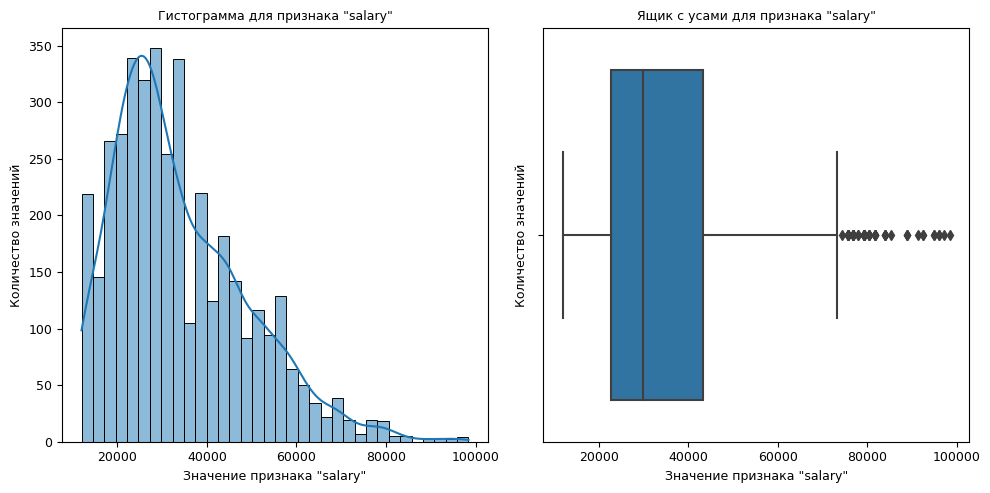

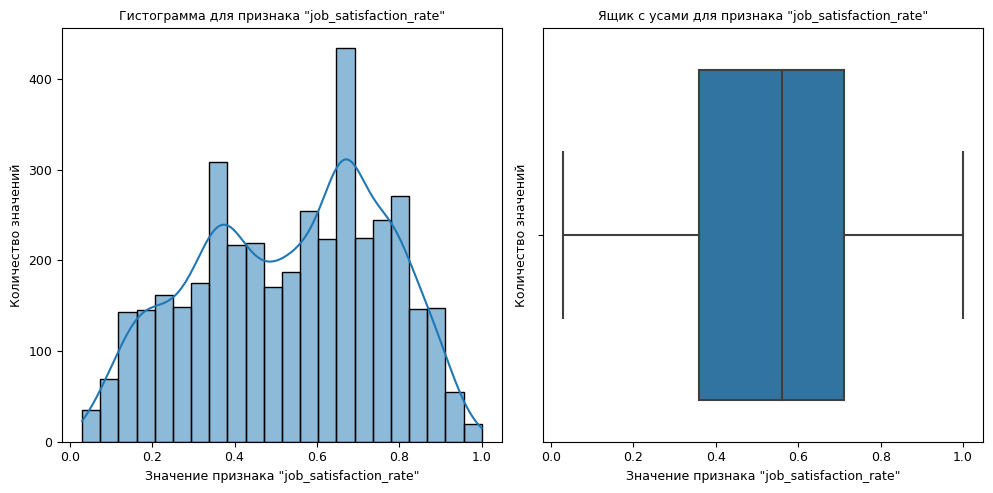

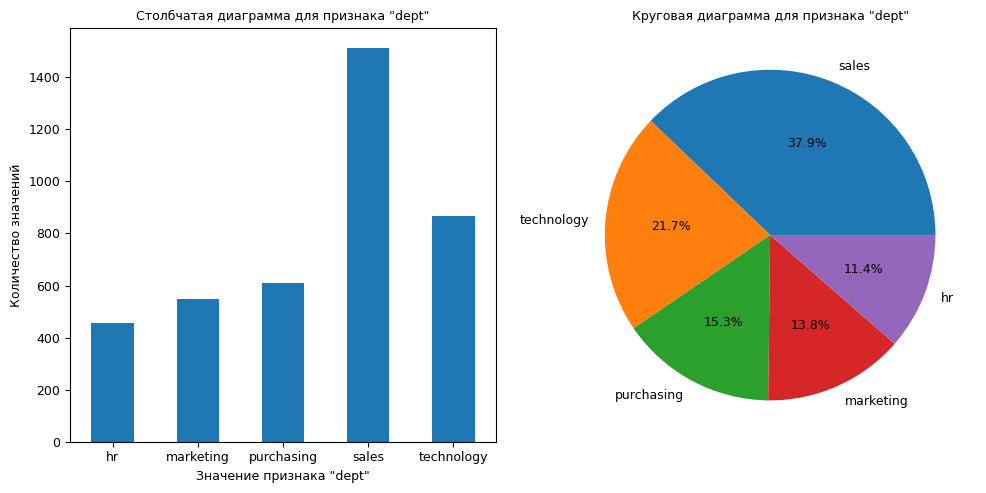

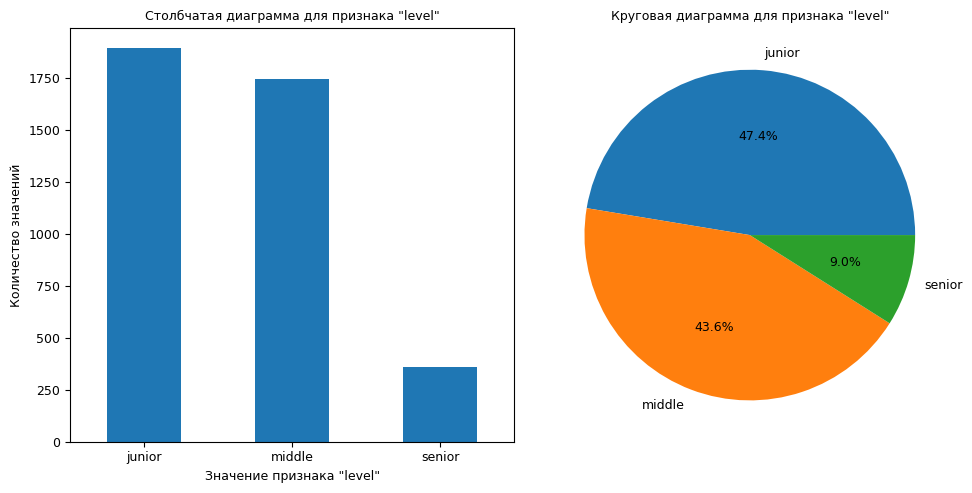

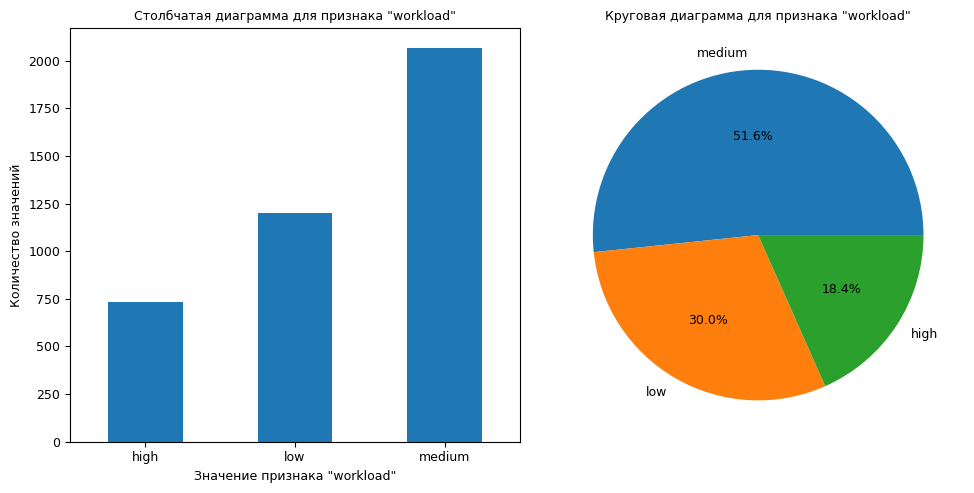

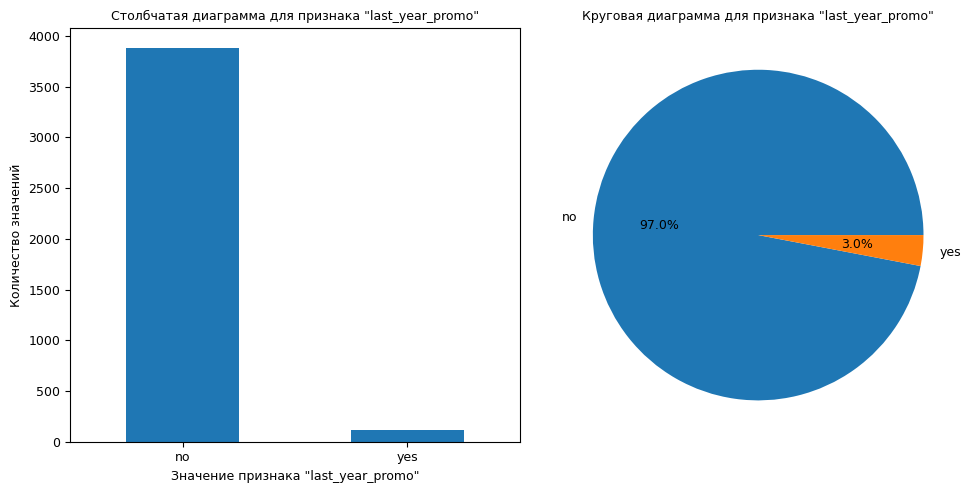

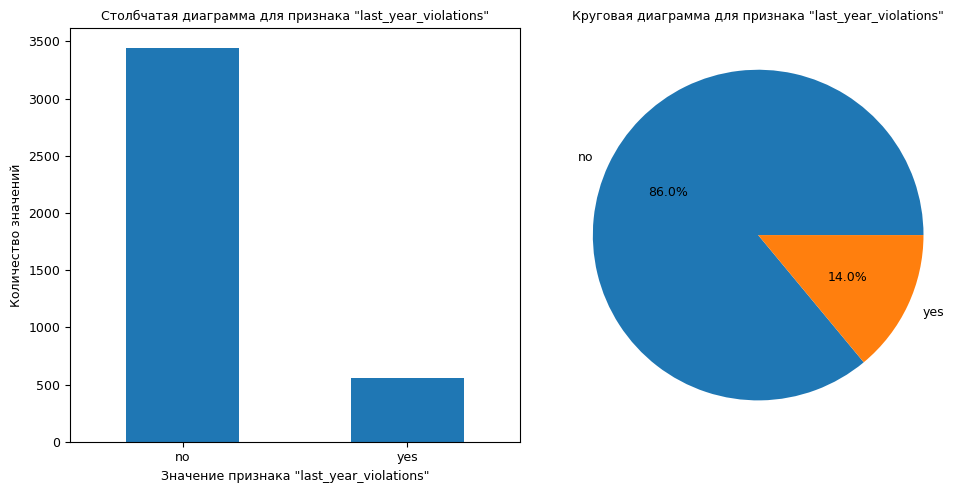

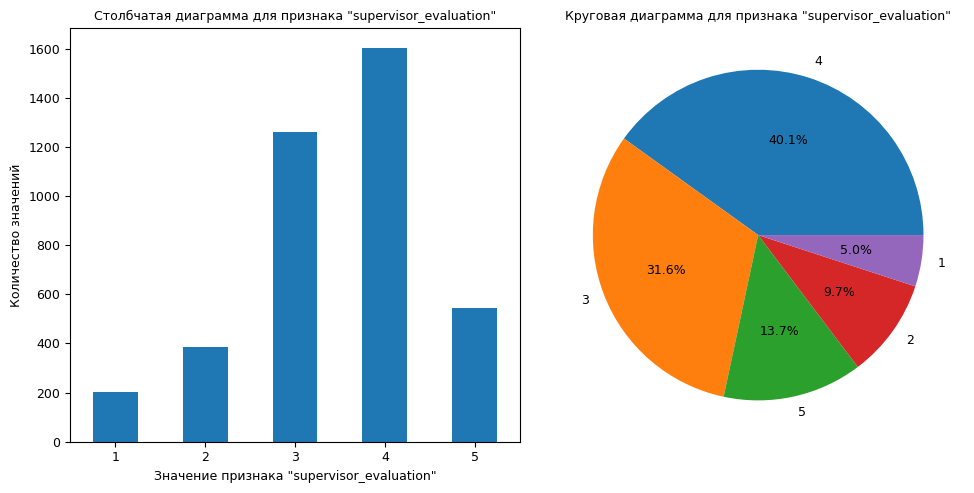

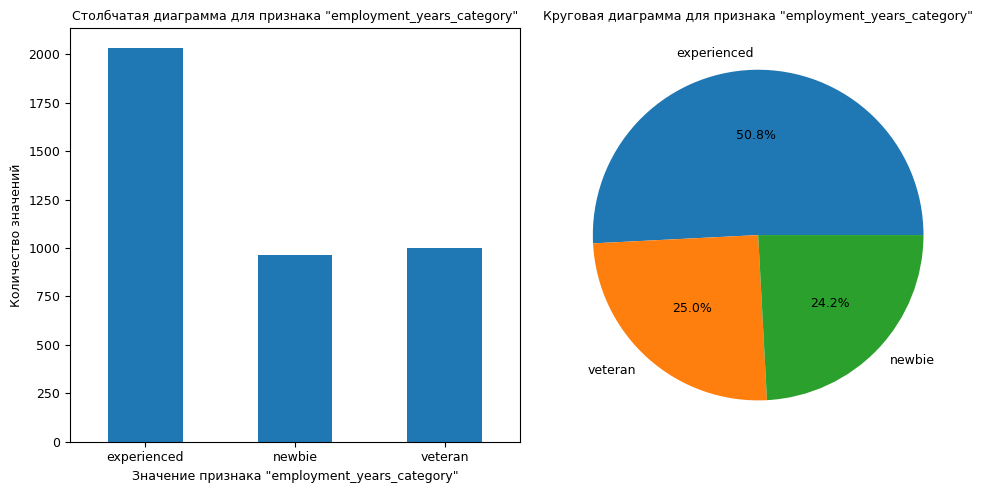

In [26]:
train_job_num_names = train_job_num.columns.to_list()
train_job_cat_names = train_job_cat.columns.to_list()

train_job_num_names.remove('employment_years')
train_job_num_names.remove('supervisor_evaluation')
train_job_cat_names.append('supervisor_evaluation')
train_job_cat_names.append('employment_years_category')

visualize_data(train_job_copy, train_job_num_names, train_job_cat_names, font_size_delta=1)

##### Корреляционный анализ.

Проведем корреляционный анализ датасета при помощи инструментов библиотеки `phik`.

In [27]:
def phik_matrix_display(df: pd.DataFrame):
    interval_cols = df.select_dtypes(exclude=['object']).drop(columns=['id']).columns.to_list()
    interval_cols.remove('employment_years')
    interval_cols.remove('supervisor_evaluation')
    print(interval_cols)
    
    phik_matrix = df.drop(columns=['id']).phik_matrix(interval_cols=interval_cols)

    plot_correlation_matrix(
        phik_matrix.values,
        x_labels=phik_matrix.columns,
        y_labels=phik_matrix.index,
        vmin=0, vmax=1, color_map='Greens',
        title=r'Матрица корреляции $\phi_K$',
        fontsize_factor=1.5,
        figsize=(20, 15)
    )

['salary', 'job_satisfaction_rate']


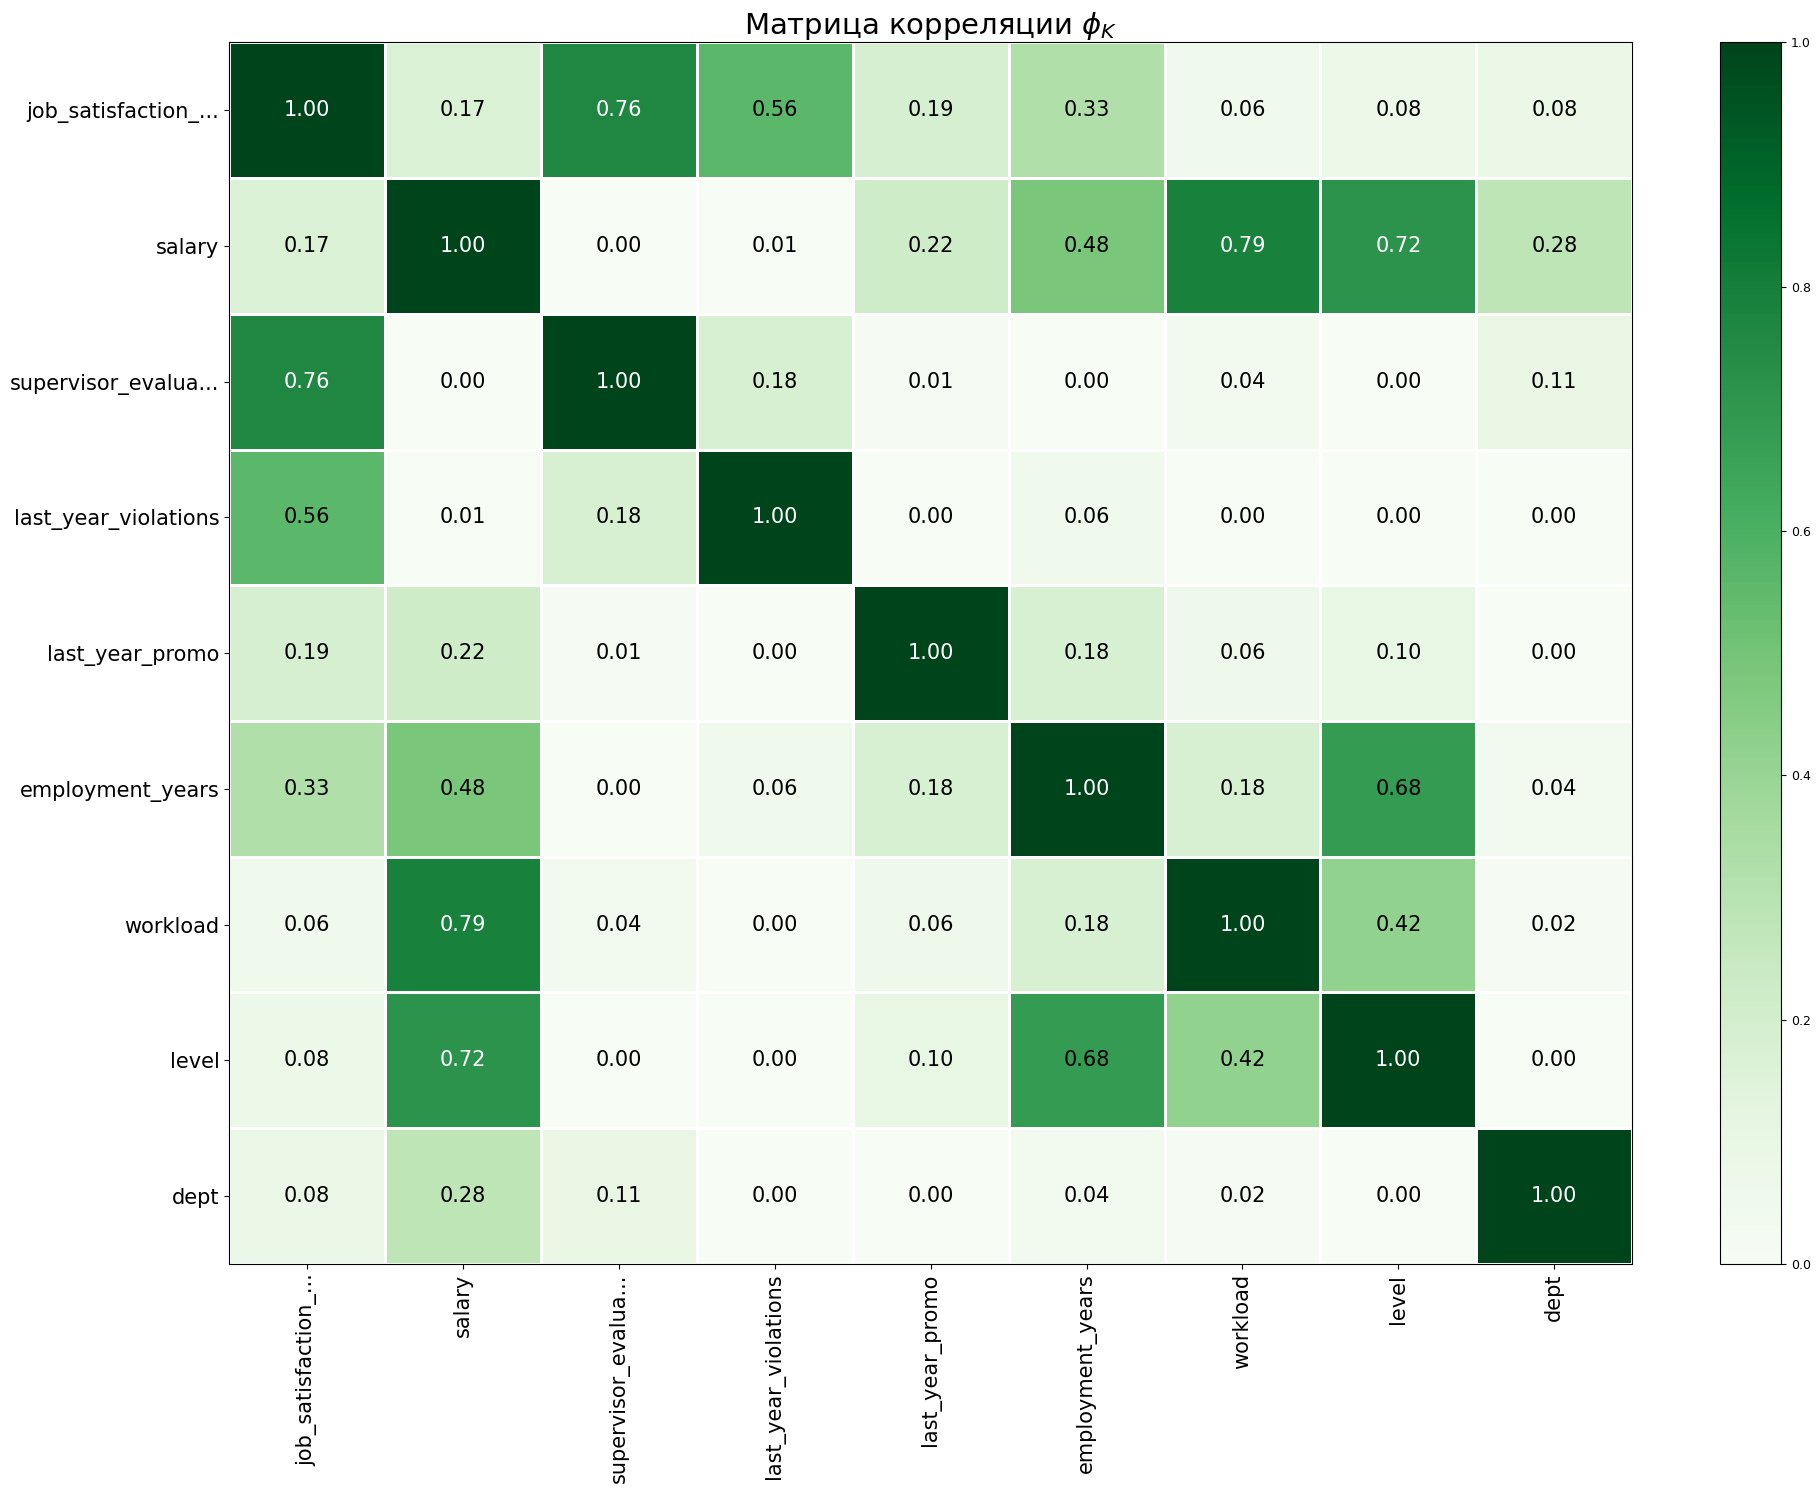

In [28]:
phik_matrix_display(train_job_satisfaction_rate)

Опираясь на шкалу Чеддока:
    
1. Между парами признаков (`supervisor_evaluation`, `job_satisfaction_rate`), (`workload`, `salary`) и (`level`, `salary`) существует высокая связь, которая объясняется довольно логично жизненным опытом: чем выше должность сотрудника, тем больше у него зарплата, больше зарплата — больше рабочей нагрузки. Неожиданностью можно назвать только связь оценки со стороны руководителя и нашим целевым признаком;
2. Между парами признаков (`level`, `employment_years`) и (`last_year_violations`, `job_satisfaction_rate`) существует заметная связь. Так же вполне логично: опыт работы в компании линейно связан с грейдом. Можно предположить, что низкий уровень удовлетворенности работой в компании влечет за собой соответствующее отношение к рабочим инструкциям: работник не заинтересован в их соблюдении;
3. Между парами признаков (`employment_years`, `job_satisfaction_rate`), (`employment_years`, `salary`) и (`workload`, `level`) существует умеренная связь. Можно предположить, что если сотрудник работает в компании довольно продолжительное время, то его устраивают условия и зарплата, которые предоставляет компания. Чем выше грейд, тем, в среднем, выше рабочая нагрузка;
4. Между парами признаков (`salary`, `job_satisfaction_rate`), (`last_year_violations`, `supervisor_evaluation`), (`last_year_promo`, `salary`), (`last_year_promo`, `job_satisfaction_rate`), (`last_year_promo`, `employment_years`), (`workload`, `employment_years`), (`last_year_promo`, `level`) и (`dept`, `supervisor_evaluation`) существует слабая связь.

Будем считать, что о мультиколлинеарности можно говорить при показателе коэффициента корреляции выше 0.9. В нашем случае таких значений нет.

##### Выводы.

1. `salary`. Имеет нормально распределение со значительным смещением вправо. Большинство значений зарплат расположено в диапазоне от 20,000 до 40,000. Существует значительное число выбросов, что указывает на наличие некоторого количества очень высоких зарплат. Статистический анализ так же подтверждает, что есть серьезные разрывы между уровнем зарплат. 
2. `job_satisfaction_rate`. Наш целевой признак. Распределение походит на бимодальное с пиками в окрестностях 0.4 и 0.6. Пик в окрестности 0.4 свидетельствует о том, что заметная часть сотрудников оценивает свою удовлетворенность работой чуть ниже среднего уровня. И наоборот, пик в окрестностях 0.6 говорит, что многие сотрудники оценивают свою удовлетворенность работой немного выше среднего уровня. Минимальное значение в 0.03 свидетельствуют о том, что есть сотрудники, которых абсолютно не устраивает работа в компании;
3. `dept`. Больше трети сотрудников (37.2%) работают в департаменте продаж, пятая часть — в технологиях  (21.7%) и по убыванию: закупки (15.3%), маркетинг (13.8%) и найм (11.4%);
4. `level`. Почти половина сотрудников (47.4%) имеет грейд `junior`. 43.6% — `middle` и лишь 9% имеет высокий уровень занимаемой должности. Это может говорить о перенасыщении относительно новыми сотрудниками, за которыми нужен дополнительный присмотр;
5. `workload`. Чуть больше половины сотрудников имеют средний уровень загруженности, 30% — низкий и 18.4% — повышенный;
6. `last_year_promo`. Всего лишь 3% сотрудников получили повышение в этом году. В компании явно стараются лишний раз не повышать сотрудников. Это может сильно влиять на уровень удовлетворенности;
7. `last_year_violations`. 14% сотрудников нарушали трудовой договор за последний год;
8. `supervisor_evaluation`. Руководители оценивают качество работы большей части сотрудников как среднее (показатель 3 — 31.6%) и выше среднего (показатель 4 — 40.1%). Наилучшую оценку от руководителя получили 13.7% сотрудников, наихудшую — 5%. И оценку 2 получило 9.7% работников;
9. `employment_years_category`. Половина сотрудников (50.8%) работает в компании от двух до пяти лет включительно. И примерно в равных долях распределены опытные сотрудники с более, чем пятилетним стажем (25%) и новички с опытом работы до года включительно (24.2)%. Эти данные не соотносятся с уровнем занимаемой должности: компания явно не продвигает сотрудников, которые уже довольно длительное время находятся на занимаемой должности.

#### `test_features`

По аналогии, рассмотрим входные данные тестовой выборки.

In [29]:
test_features_num, test_features_cat = num_cat_split(test_features)

In [30]:
test_features_num.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
employment_years,2000.0,3.67,2.54,1.0,1.0,3.0,6.0,10.0
supervisor_evaluation,2000.0,3.53,1.00,1.0,3.0,4.0,4.0,5.0
salary,2000.0,34066.80,15398.44,12000.0,22800.0,30000.0,43200.0,96000.0


In [31]:
test_features_copy = test_features.copy()

test_features_copy['employment_years_category'] = test_features['employment_years'].apply(categorize_employment_years)

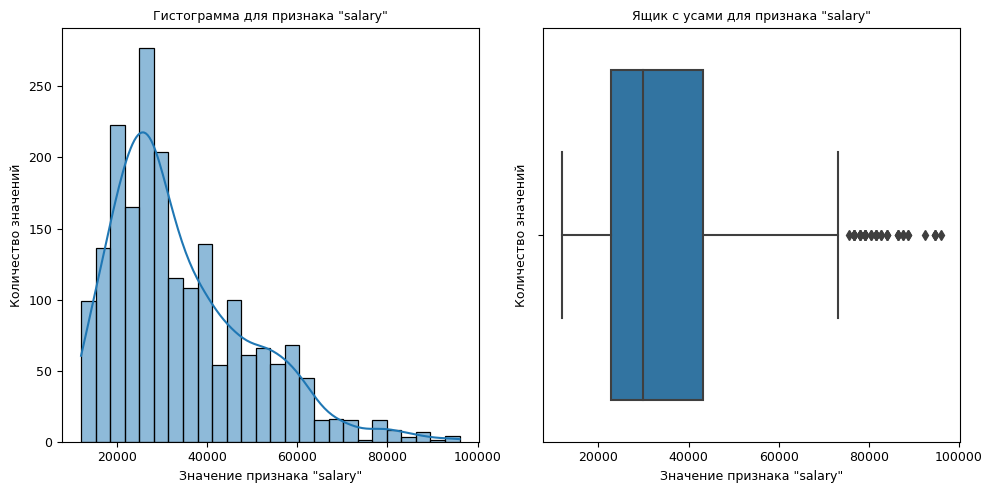

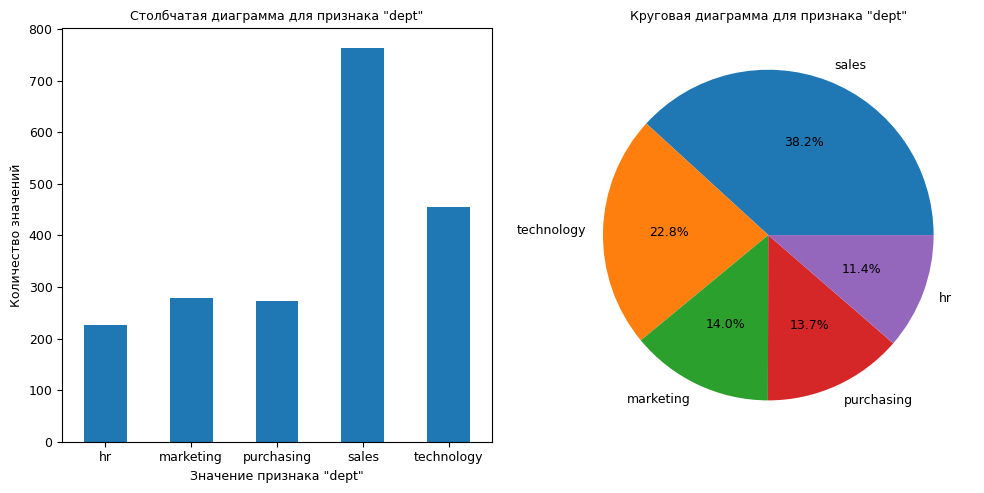

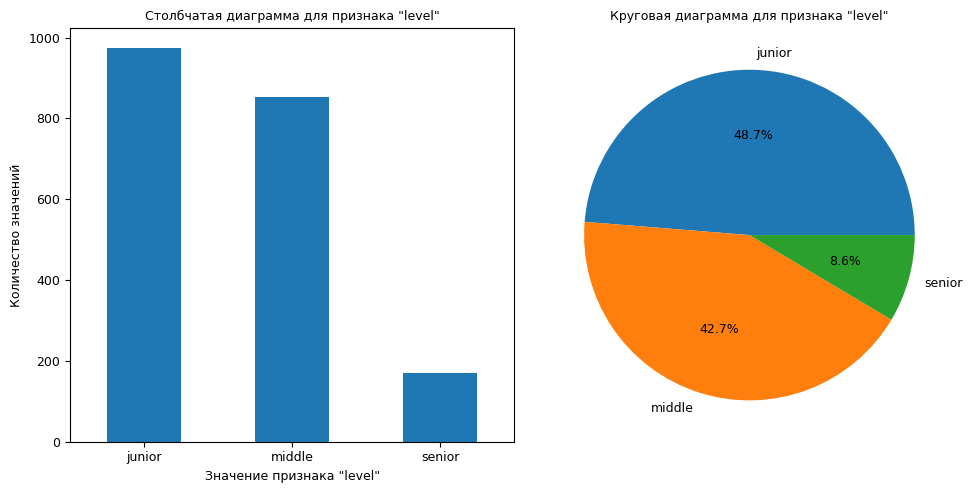

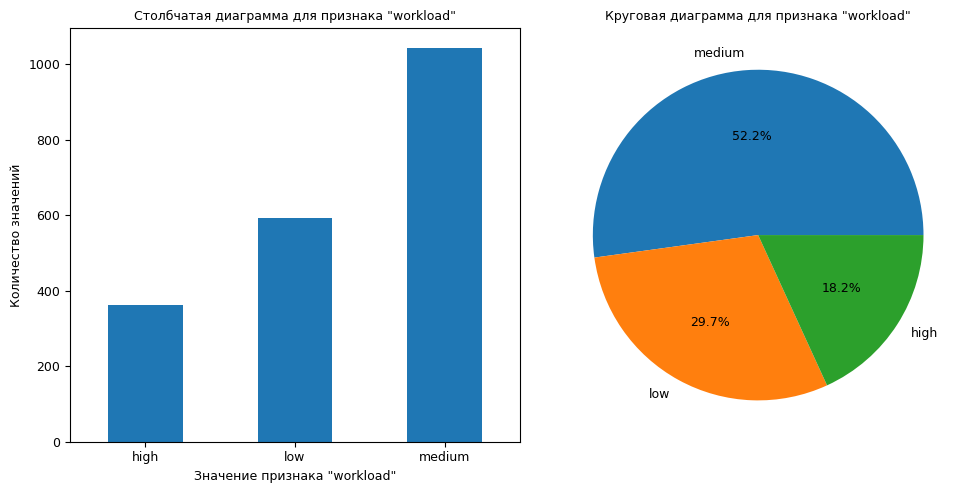

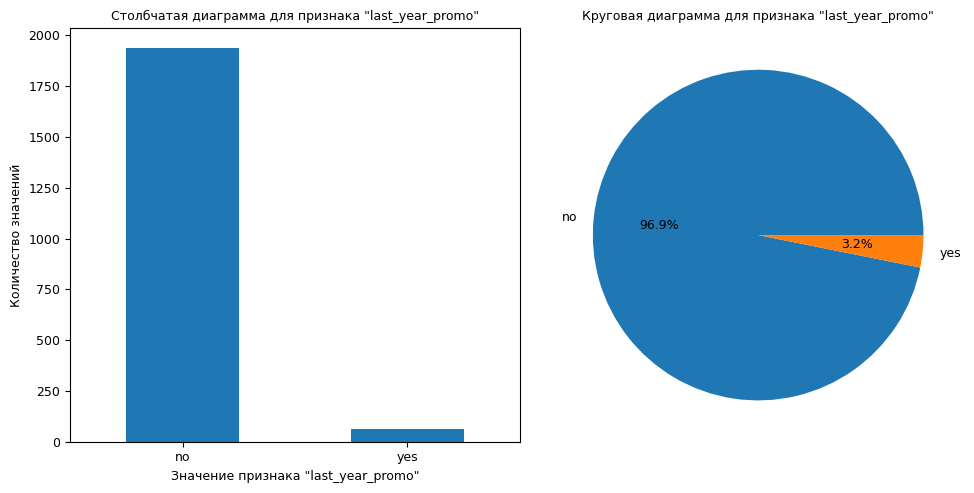

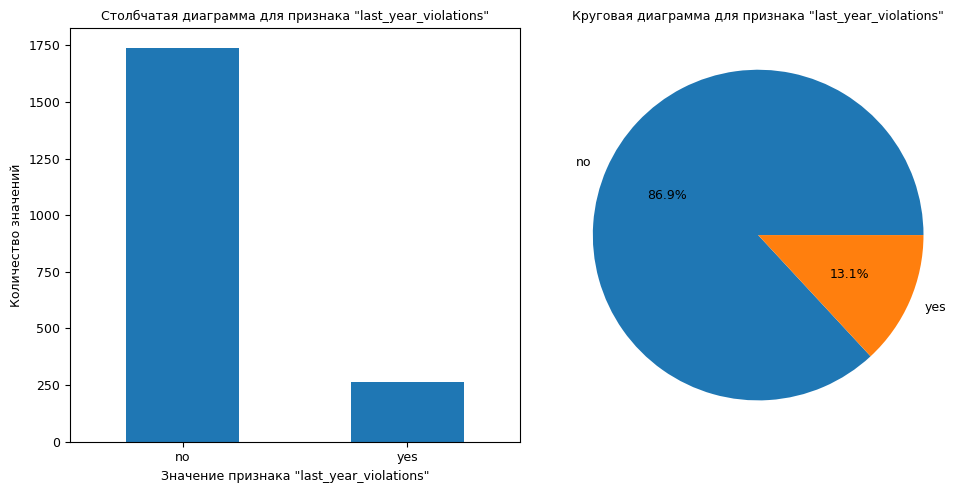

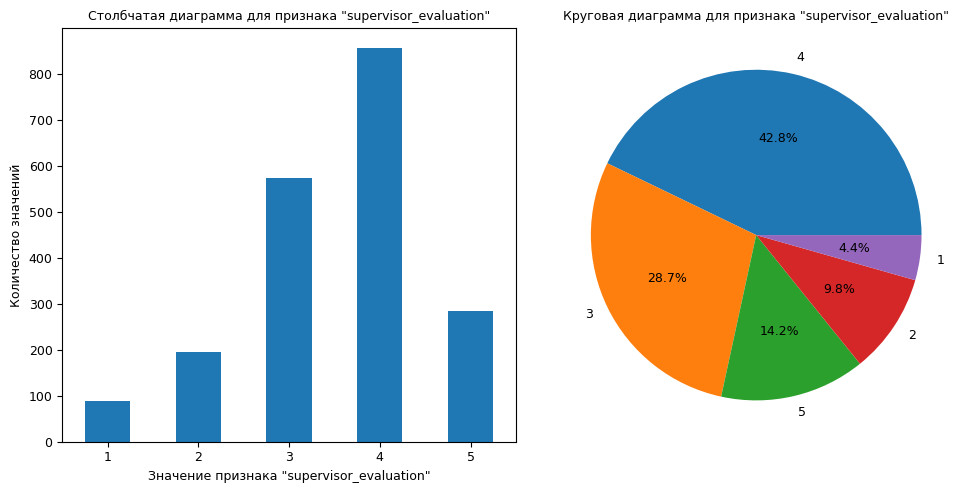

In [32]:
test_features_num_names = test_features_num.columns.to_list()
test_features_cat_names = test_features_cat.columns.to_list()

test_features_num_names.remove('employment_years')
test_features_num_names.remove('supervisor_evaluation')
test_features_cat_names.append('supervisor_evaluation')

visualize_data(test_features_copy, test_features_num_names, test_features_cat_names)

##### Корреляционный анализ.

Добавим таргет к нашим тестовым данным и, по примеру предыдущего датасета, проведем корреляционный анализ признаков.

['salary', 'job_satisfaction_rate']


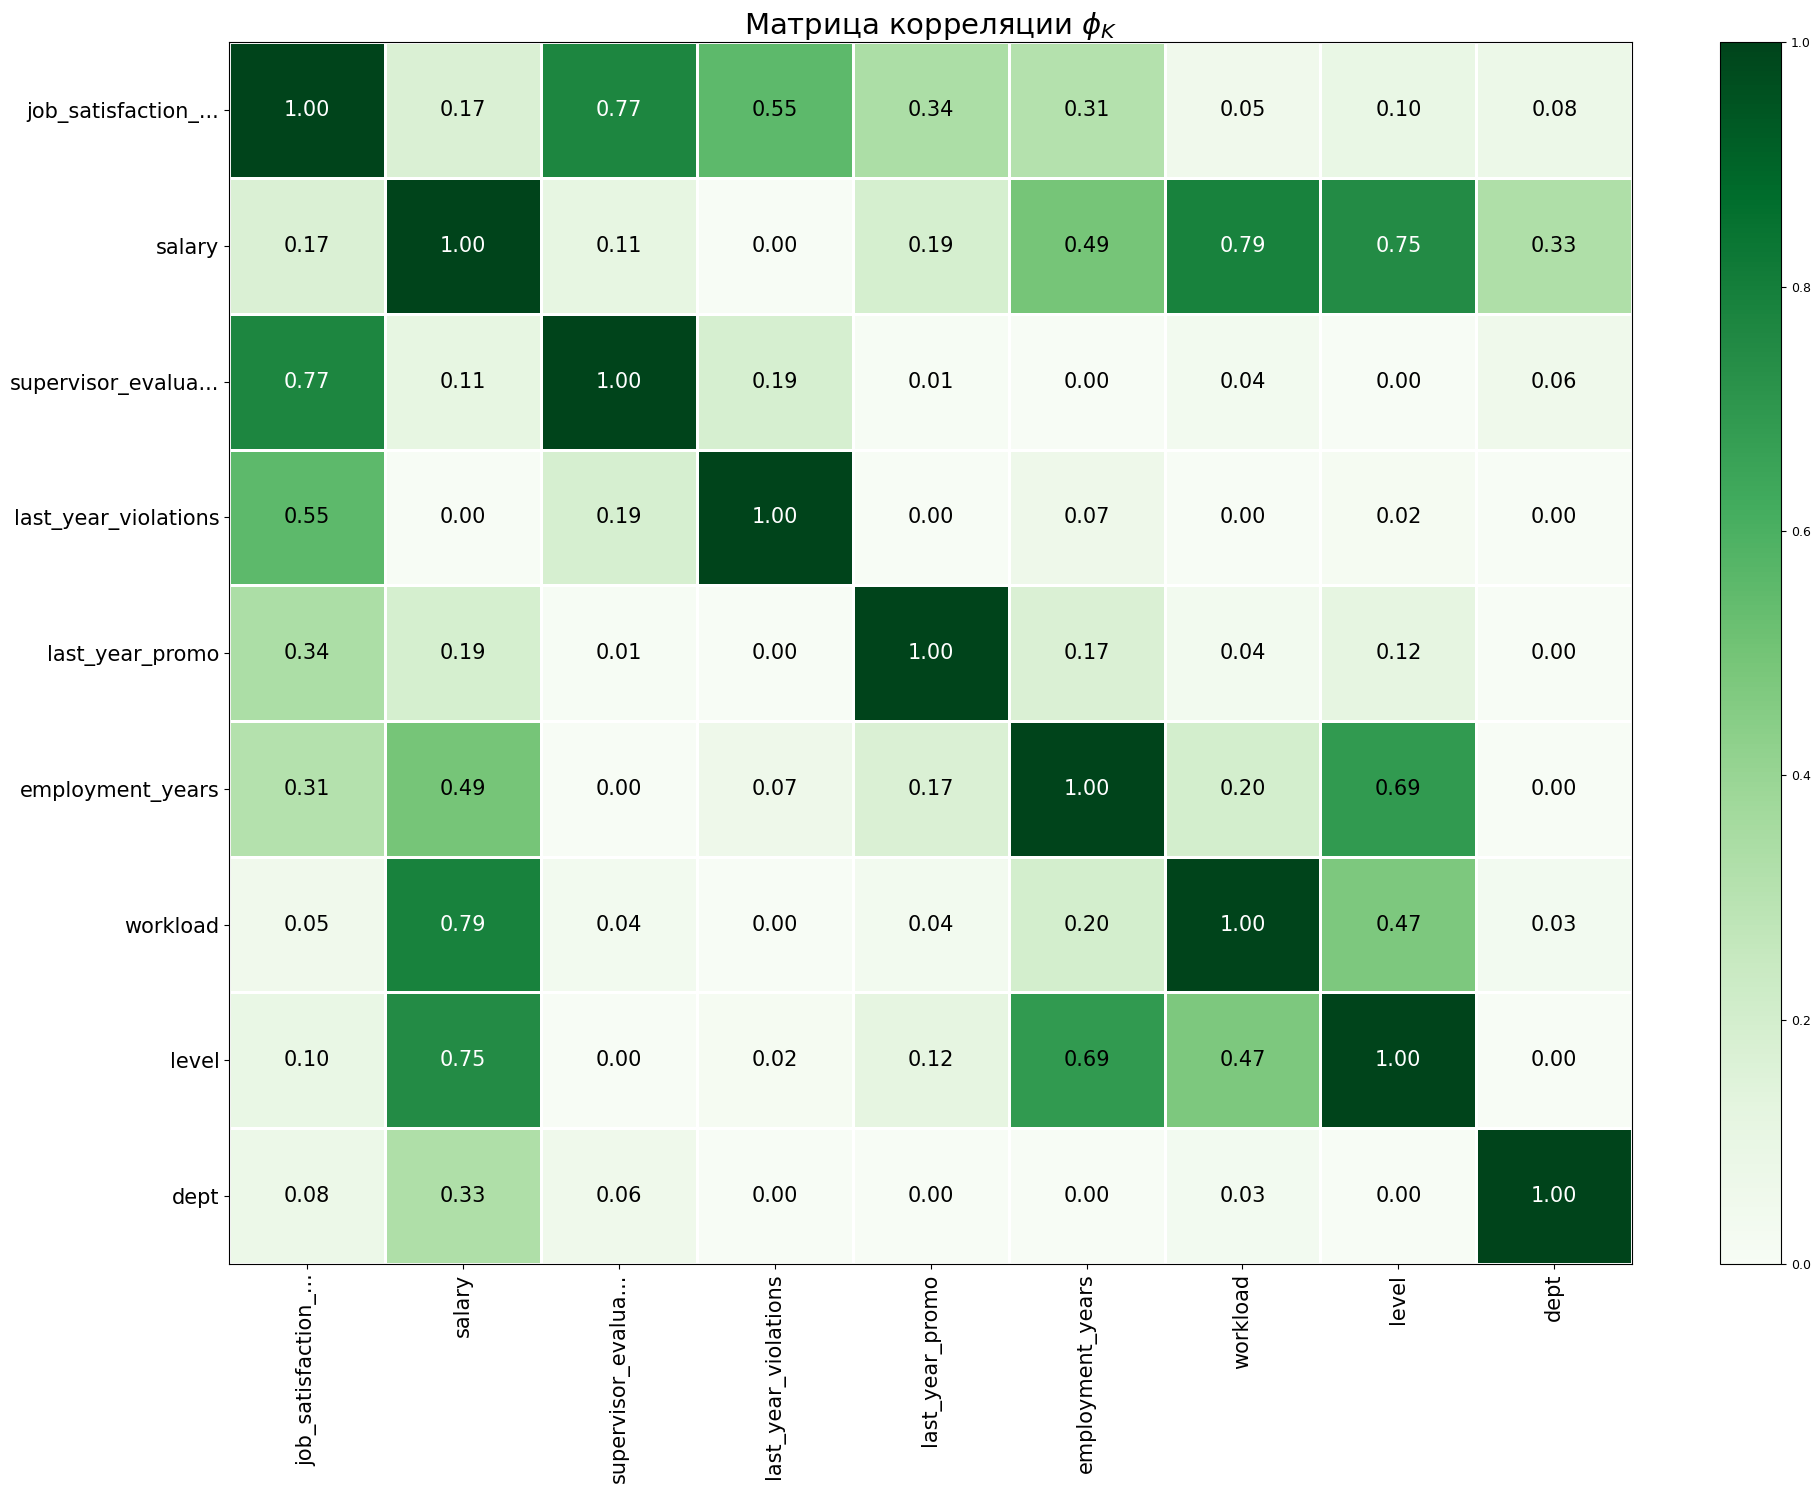

In [33]:
phik_matrix_display(test_features.merge(test_target_job_satisfaction_rate, on='id', how='left'))

Сразу же можно заметить, что тестовые данные во многом походят на тренировочные. Матрица корреляции это так же подтверждает. Кратко сформулируем результаты.

1. Между парами признаков (`job_satisfaction_rate`, `supervisor_evaluation`),(`salary`, `workload`) и (`salary`, `level`) имеется сильная связь;
2. Между парами признаков (`employment_years`, `level`) и (`job_satisfaction_rate`, `last_year_violations`) имеется заметная связь;
3. Между парами признаков (`job_satisfaction_rate`, `last_year_promo`), (`job_satisfaction_rate`, `employment_years`)(`employment_years`, `salary`), (`level`, `workload`) и (`salary`, `dept`) имеется умеренная связь. Влияние отдела, в котором работает сотрудник, на тестовых данных оказывает более сильное влияние, относительно тренировочных;
4. Между парами признаков (`salary`, `supervisor_evaluation`), (`last_year_violations`, `supervisor_evaluation`), (`last_year_promo`, `salary`), (`last_year_promo`, `employment_years`), (`workload`, `employment_years`), (`level`, `last_year_promo`), (`job_satisfaction_rate`, `salary`) и (`job_satisfaction_rate`, `level`) имеется слабая связь;
5. Между признаками тестовой выброки нет мультиколлинеарности.

##### Выводы.

В общем и целом, можно сказать, что распределение значений тестовой выборки чуть ли не с единичной точностью повторяет тренировочную. Это может говорить о том, что итоговая модель будет довольно хорошо предсказывать уровень удовлетворенности сотрудников. Кратко опишем результаты:

1. `salary`. Распределение походит на нормальное со значительным правым перекосом. Основная масса значений сосредоточена между 20,000 и 40,000. Такая же группа сотрудников с зарплатами, намного превышающими среднюю по компании;
2. `dept`. Распределение сотрудников по департаментам в процентных долях от общего числа: продажи — 38.2%, технический — 22.4%, маркетинг — 14%, закупки — 13.7% и hr — 11.4%;
3. `level`. Низкий уровень должности — 48.7%, средний — 42.7% и высокий — 8.6%;
4. `workload`. 52.2% сотрудников имеют средний уровень рабочей нагрузки, 29.7% — низкий и 18.2% высокий;
5. `last_year_promo`. 3.2% сотрудников получили повышение за последний год;
6. `last_year_violations`. 13.1% сотрудников нарушали условия трудового договора за последний год;
7. `employment_years_category`. Процетные доли сотрудников по категориям срока работы в компании: до одного года включительно — 26.1%, от двух до пяти лет — 48.7% и свыше пяти лет — 25.2%;
8. `supervisor_evaluation`. Высшую оценку со стороны руководства получили 14.2% сотрудников, выше среднего — 42.8%, среднюю — 28.7%, ниже среднего — 9.8% и наименьшую — 4.4%.

#### `test_target_job_satisfaction_rate`

Рассмотрим распределение значений целевого признака на тестовой выборке.

In [34]:
test_target_job_satisfaction_rate['job_satisfaction_rate'].describe()

count    2000.00000
mean        0.54878
std         0.22011
min         0.03000
25%         0.38000
50%         0.58000
75%         0.72000
max         1.00000
Name: job_satisfaction_rate, dtype: float64

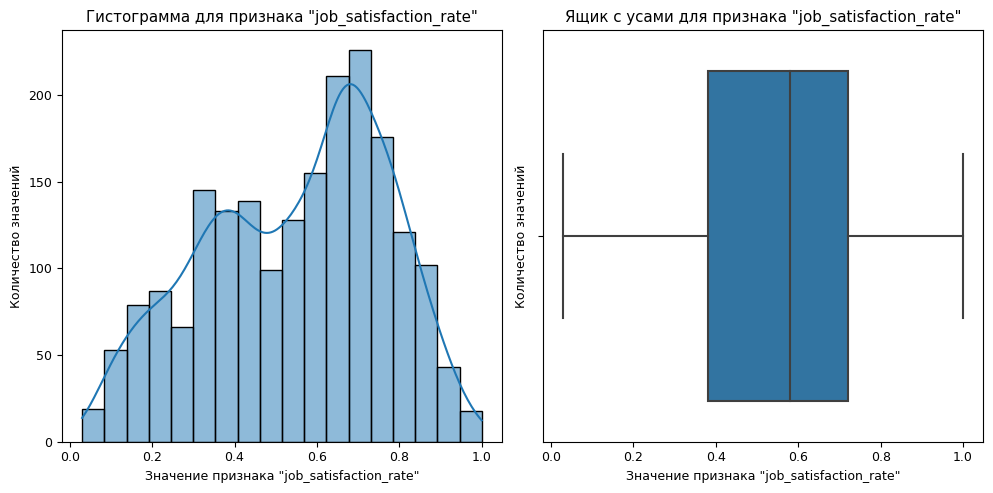

In [35]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.histplot(test_target_job_satisfaction_rate['job_satisfaction_rate'], kde=True)
plt.title(f'Гистограмма для признака "job_satisfaction_rate"')
plt.xlabel(f'Значение признака "job_satisfaction_rate"')
plt.ylabel('Количество значений')

plt.subplot(1, 2, 2)
sns.boxplot(x=test_target_job_satisfaction_rate['job_satisfaction_rate'])
plt.title(f'Ящик с усами для признака "job_satisfaction_rate"')
plt.xlabel(f'Значение признака "job_satisfaction_rate"')
plt.ylabel('Количество значений')

plt.tight_layout()
plt.show()

##### Выводы.

1. Схожая ситуация, что и на тренировочных данных: бимодальное распределение с пиками в окрестностях 0.4 и 0.6.

#### Выводы по подготовке признаков.

1. Признаки `salary` и `employment_years` будем масштабировать при помощи `StandardScaler` и `MinMaxScaler`;
2. Целевой параметр `job_satisfaction_rate` находится в диапазоне от 0 до 1 и не нуждается в дополнительной подготовке;
3. Признаки `dept`, `last_year_promo` и `last_year_violations` являются дискретными. Закодируем их при помощи `OneHotEncoder`;
4. Признаки `level`, `workload` и `supervisor_evaluation` имеют ранговую структуру. При их подготовке воспользуемся `OrdinalEncoder`.

### Подготовка данных

Сформируем паплайн преодработки и подготовки данных. Учтем выводы и комментарии, сделанные на предыдущих этапах.

#### Пайплайн предоработки и подготовки данных.

In [36]:
num_columns = ['salary', 'employment_years']
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload', 'supervisor_evaluation']

ordinal_categories = [
    ['unknown', 'junior', 'middle', 'senior'],
    ['unknown', 'low', 'medium', 'high'],
    [-1, 1, 2, 3, 4, 5]
]

ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='unknown')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='infrequent_if_exist', sparse_output=False))
    ]
)

In [37]:
ord_pipe = Pipeline(
    [
        ('simpleImputer_ord', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='unknown')),
        ('ord', OrdinalEncoder(
            categories=ordinal_categories,
            handle_unknown='use_encoded_value', unknown_value=-1
        ))
    ]
)

data_preprocessor = ColumnTransformer(
    [
        ('num', StandardScaler(), num_columns),
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns)
    ],
    remainder='passthrough'
)

### Обучение моделей

При обучении моделей будем использовать пайплайны.

Возьмем для нашей работы различные модели: линейную регрессию, ближайших соседей, дерево решений, опорных векторов и случайный лес. Также определим список гиперпараметров, которые мы в дальнейшем будем перебирать на этапе кросс-валидации.

В качестве метрики, по условию задачи, возьмем SMAPE (англ. symmetric mean absolute percentage error, «симметричное среднее абсолютное процентное отклонение»). Определим для нее отдельную функцию.

#### Пайплайн обучения моделей.

In [38]:
def SMAPE(y_true, y_pred):
    smape = 100 / len(y_true) * sum(
        np.absolute(np.subtract(y_true, y_pred)) / (np.add(np.absolute(y_true), np.absolute(y_pred)) / 2)
    )
    return smape

In [39]:
RANDOM_STATE = 42

In [40]:
X_first = train_job_satisfaction_rate.drop(columns=['id'])

Проверим, появились ли в данных дубликаты после удаления уникальных идентификаторов для каждого пользователя. Это может оказать негативное влияние на модель при обучении.

In [41]:
if X_first.duplicated().sum() > 0:
    X_first = X_first.drop_duplicates()

y_first = X_first['job_satisfaction_rate']    
X_first = X_first.drop(columns=['job_satisfaction_rate'])

In [42]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

In [43]:
param_grid = [
    {
        'model': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'model__max_depth': range(2, 10),
        'model__min_samples_split': range(2, 10),
        'model__min_samples_leaf': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    {
        'model': [KNeighborsRegressor()],
        'model__n_neighbors': range(1, 25),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    {
        'model': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    {
        'model': [SVR()],
        'model__kernel': ['linear', 'rbf', 'sigmoid'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    {
        'model': [SVR()],
        'model__kernel': ['poly'],
        'model__degree': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    {
        'model': [RandomForestRegressor()],
        'model__n_estimators': [10, 50, 100, 150, 200],
        'model__criterion': ['squared_error', 'absolute_error'],
        'model__max_depth': range(2, 25),
        'model__min_samples_split': range(2, 25),
        'model__min_samples_leaf': range(2, 25),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring=make_scorer(SMAPE, greater_is_better=False),
    n_jobs=-1,
    n_iter=50,
    random_state=RANDOM_STATE
)

In [44]:
randomized_search.fit(X_first, y_first)

best_model = randomized_search.best_estimator_

print('Лучшая модель и её параметры:\n\n', best_model)
print('Метрика лучшей модели на кросс-валидации:', -round(randomized_search.best_score_, 2))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['salary',
                                                   'employment_years']),
                                                 ('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(fill_value='unknown',
                                                                                 strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='infrequent_if_exist',
                          

Показатель выбранной метрики $SMAPE$ на кросс-валидации — $14.42$.

Критерием успеха является $SMAPE \leq 15$ на тестовой выборке. Возьмем нашу лучшую модель и получим для нее предсказания. 

In [45]:
test_data = pd.merge(test_features, test_target_job_satisfaction_rate, on='id', how='left')

In [46]:
X_test_first = test_data.drop(columns=['id', 'job_satisfaction_rate'])
y_test_first = test_data['job_satisfaction_rate']

y_pred_test_first = best_model.predict(X_test_first)

smape_test = SMAPE(y_test_first, y_pred_test_first)
print('SMAPE на тестовой выборке:', round(smape_test, 2))

SMAPE на тестовой выборке: 12.78


Успех: целевой показатель метрики достигнут.

In [47]:
dummy_regressor = DummyRegressor(strategy='mean')
dummy_regressor.fit(X_first, y_first)
dummy_preds = dummy_regressor.predict(X_first)

smape_dummy = cross_val_score(
    dummy_regressor,
    X_first,
    y_first,
    cv=5,
    scoring=make_scorer(SMAPE, greater_is_better=False)
).mean()

print('Метрика SMAPE константной модели на тренировочной выборке:', -round(smape_dummy, 2))

Метрика SMAPE константной модели на тренировочной выборке: 40.19


Отлично. Проделанные усилия оправдались: константная модель в разы хуже нашей. 

#### Анализ важности признаков.

Проанализируем итоговый вклад признаков в предсказания моделей при помощи инструментов `SHAP`.

In [48]:
SAMPLE_SIZE = 50

100%|===================| 1999/2000 [00:22<00:00]        

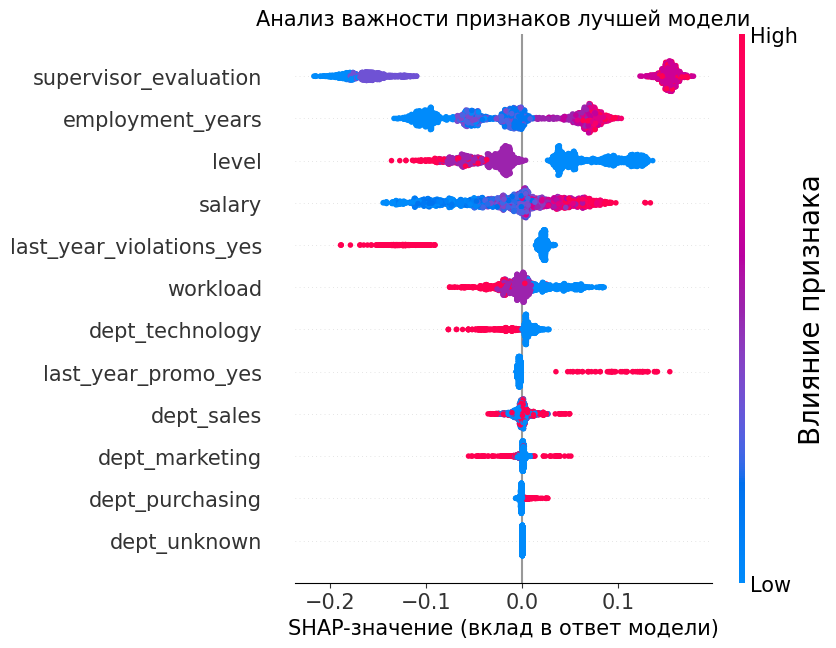

In [49]:
shap.initjs()

random_forest_model = best_model.named_steps['model']
X_test_transformed = best_model.named_steps['preprocessor'].transform(X_test_first)
X_train_transformed = best_model.named_steps['preprocessor'].transform(X_first)
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()
feature_names = [name[5:] for name in feature_names]

explainer = shap.Explainer(random_forest_model, X_train_transformed)
shap_values = explainer(X_test_transformed, check_additivity=False)

shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names, show=False)

fig, ax = plt.gcf(), plt.gca()

ax.tick_params(labelsize=15)
ax.set_xlabel('SHAP-значение (вклад в ответ модели)', fontsize=15)
ax.set_title('Анализ важности признаков лучшей модели', fontsize=15)

cb_ax = fig.axes[1] 

cb_ax.tick_params(labelsize=15)
cb_ax.set_ylabel('Влияние признака', fontsize=20)

plt.show()

PermutationExplainer explainer: 51it [00:11,  1.14s/it]                        


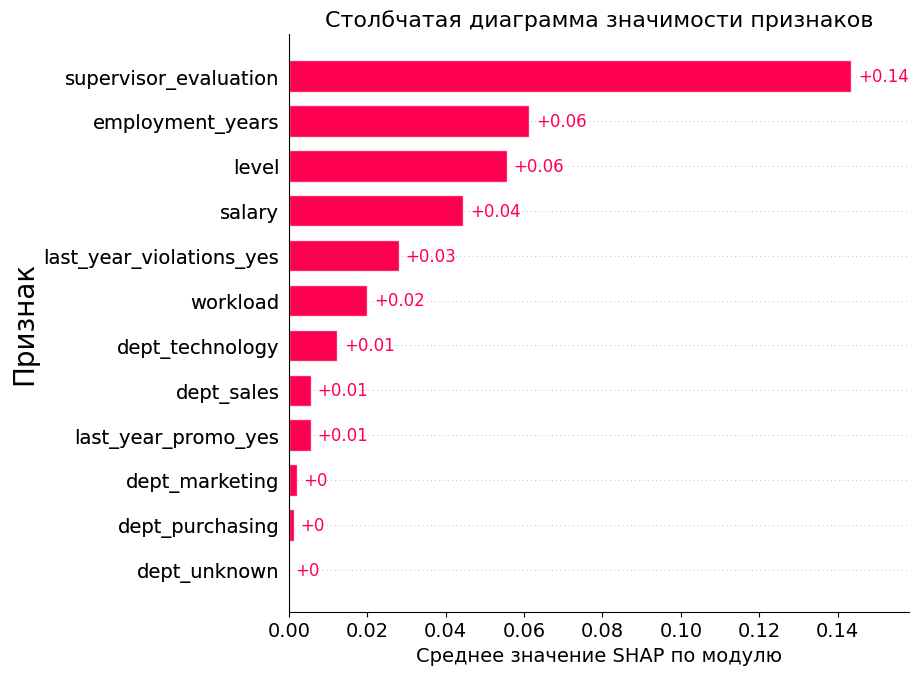

In [50]:
train_sample = shap.sample(X_train_transformed, SAMPLE_SIZE, random_state=RANDOM_STATE)
test_sample = shap.sample(X_test_transformed, SAMPLE_SIZE, random_state=RANDOM_STATE)

explainer = shap.Explainer(random_forest_model.predict, train_sample, feature_names=feature_names)

shap_values = explainer(test_sample)

shap.plots.bar(shap_values, max_display=len(feature_names), show=False)

ax = plt.gca()

ax.tick_params(labelsize=14)
ax.set_xlabel('Среднее значение SHAP по модулю', fontsize=14)
ax.set_title('Столбчатая диаграмма значимости признаков', fontsize=16)
ax.set_ylabel('Признак', fontsize=20)

plt.show()

#### Выводы.

1. Мы обучили пять моделей машинного обучения с целью поиска наилучшей для нашего кейса;
2. Для каждой из моделей мы перебрали несколько гиперпараметров;
3. Лучшей моделью по результатам кросс-валидации стал случайный лес;
4. Итоговый показатель метрики $SMAPE$ лучшей модели на тестовой выборке — $12.78$;
5. Наиболее важными для модели стали признаки: оценка со стороны руководства, срок работы в компании, грейд и зарплата сотрудника;
6. Наименее важные признаки — отдел и булево значение: было ли повышение у сотрудника за последний год или нет.

### Выводы

В рамках этой задачи нам необходимо было построить модель машинного обучения, которая бы предсказывала уровень удовлетворенности работой в компании для каждого сотрудника. Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.

Лучше всего с задачей справилась модель случайного леса с показателем выбранной метрики $SMAPE = 12.78$. Критерий успеха заказчика был выполнен. Наиболее важными для модели стали признаки: оценка со стороны руководства, срок работы в компании, грейд и зарплата сотрудника. То есть, если компания захочет увеличивать показатель удовлетворенности сотрудников, то обращать внимание стоит именно на эти признаки.

## Задача 2: предсказание увольнения сотрудника из компании

В рамках этой задачи мы должны будем получить модель классификации, которая бы позволяла определить: уволится сотрудник или нет. Мы добавим предсказания уровня удовлетворенности в тренировочные данные при помощи лучшей модели из предыдущей задачи и будем учитывать этот признак при разработке модели. Критерий успеха от заказчика — метрика $ROC-AUC \geq 0.91$ на тестовой выборке. 

### Загрузка данных

In [51]:
additional_local_paths = {
    'train_quit': '/datasets/train_quit.csv',
    'test_target_quit': '/datasets/test_target_quit.csv'
}

additional_url_paths = {
    'train_quit': 'https://code.s3.yandex.net/datasets/train_quit.csv',
    'test_target_quit': 'https://code.s3.yandex.net/datasets/test_target_quit.csv'
}

local_paths.update(additional_local_paths)
url_paths.update(additional_url_paths)

train_quit = read_csv_file(local_paths['train_quit'], url_paths['train_quit'])
test_target_quit = read_csv_file(local_paths['test_target_quit'], url_paths['test_target_quit'])

Проверим, что данные соответствуют предоставленному описанию.

In [52]:
train_quit.info()
train_quit.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [53]:
test_target_quit.info()
test_target_quit.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


Структура данных не поменялась. Так же, как и при решении первой задачи, у нас в распоряжении находится 4000 записей о сотрудниках. 

На этот раз явных пропусков в данных нет.

### Предобработка данных

#### Обработка пропущенных значений.

In [54]:
second_task_frames = [train_quit, test_target_quit]

for frame in second_task_frames:
    print(frame.isna().sum(), '\n')

id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64 

id      0
quit    0
dtype: int64 



Явных пропусков, как и упоминалось ранее, нет.

#### Обработка повторяющихся значений.

In [55]:
for frame in second_task_frames:
    print(frame.duplicated().sum())

0
0


Явных дубликатов нет. Изучим уникальные значения каждого из столбцов наших датасетов.

In [56]:
print_unique_values(second_task_frames)

Столбец "dept": ['sales' 'purchasing' 'marketing' 'technology' 'hr']
Столбец "level": ['middle' 'junior' 'sinior']
Столбец "workload": ['high' 'medium' 'low']
Столбец "last_year_promo": ['no' 'yes']
Столбец "last_year_violations": ['no' 'yes']
Столбец "quit": ['no' 'yes']

Столбец "quit": ['yes' 'no']



Неявных дубликатов так же не обнаружено. По аналогии с предыдущей задачей, заменим `sinior` на `senior`.

In [57]:
train_quit['level'] = train_quit['level'].replace('sinior', 'senior')
train_quit['level'].unique()

array(['middle', 'junior', 'senior'], dtype=object)

#### Выводы.

1. Типы данных во всех датафреймах соответствуют своему заявленному содержимому;
2. В данных нет пропущенных и повторяющихся значений;
3. Названия столбцов и их содержимое соответствуют кодстайлу.

### Исследовательский анализ данных

#### `train_quit`

In [58]:
train_quit_num, train_quit_cat = num_cat_split(train_quit)

In [59]:
train_quit_num.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
employment_years,4000.0,3.70,2.54,1.0,2.0,3.0,6.0,10.0
supervisor_evaluation,4000.0,3.47,1.00,1.0,3.0,4.0,4.0,5.0
salary,4000.0,33805.80,15152.42,12000.0,22800.0,30000.0,43200.0,96000.0


Данные не изменились по своей структуре, поэтому проделаем все те же процедуры, что и в первой задаче.

In [60]:
train_quit_copy = train_quit.copy()

train_quit_copy['employment_years_category'] = train_quit['employment_years'].apply(categorize_employment_years)

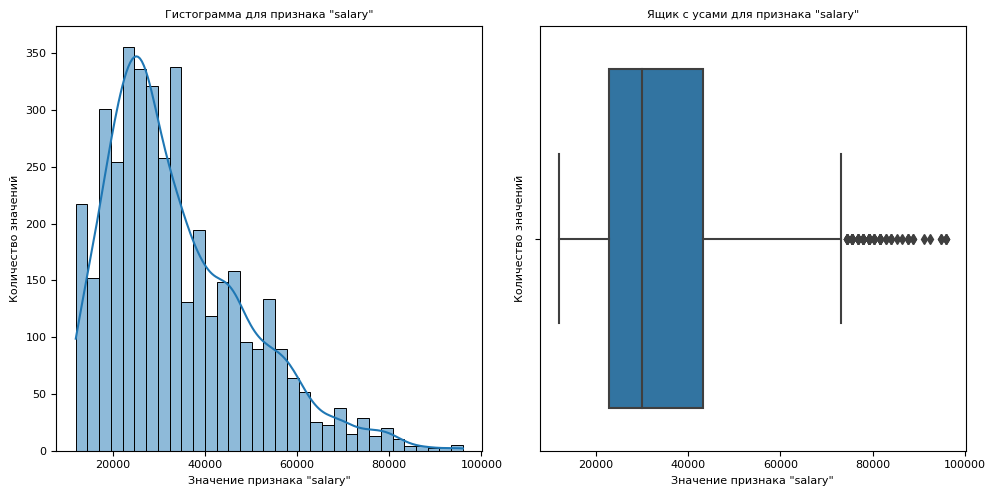

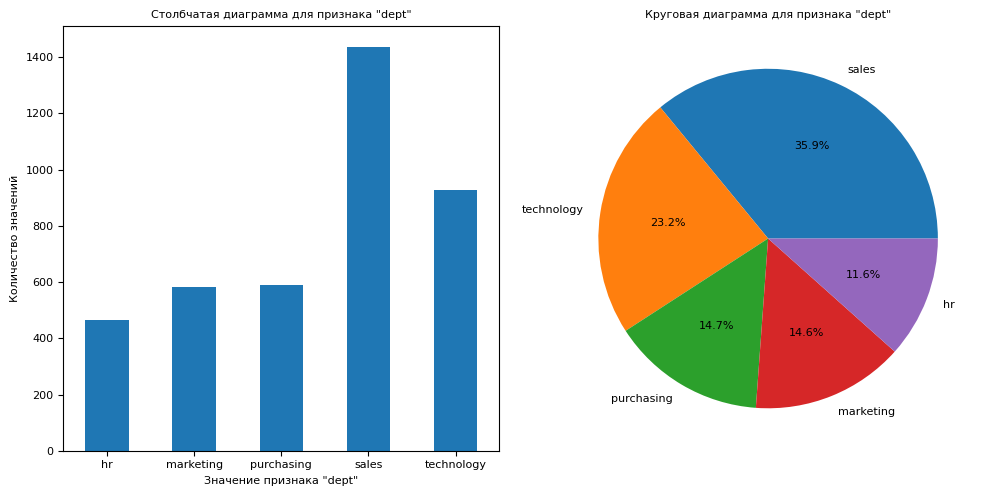

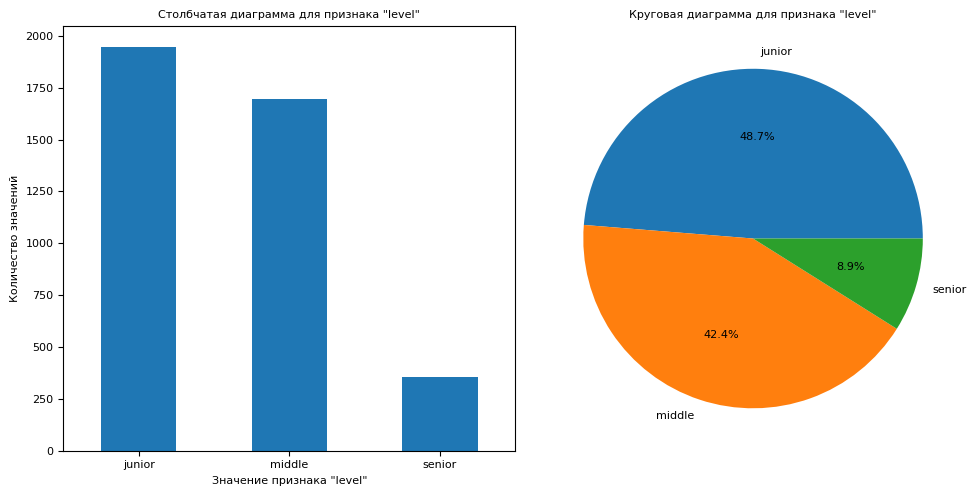

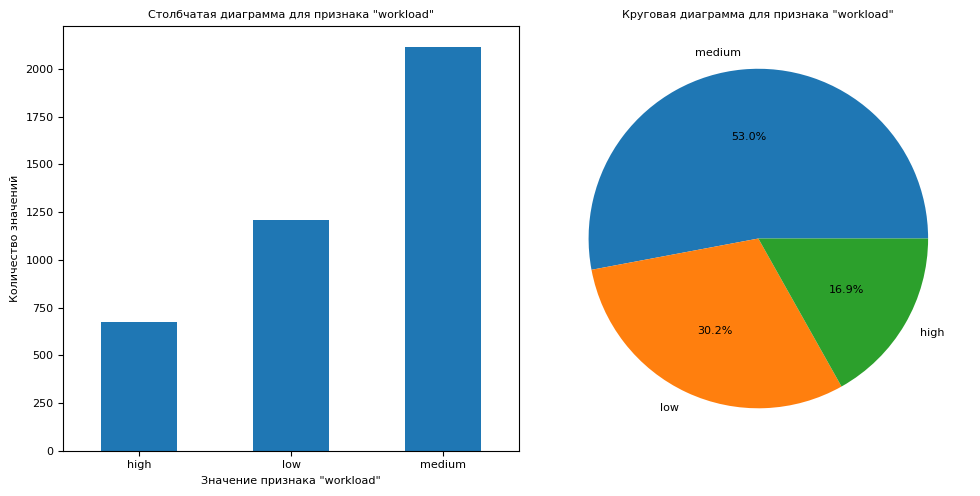

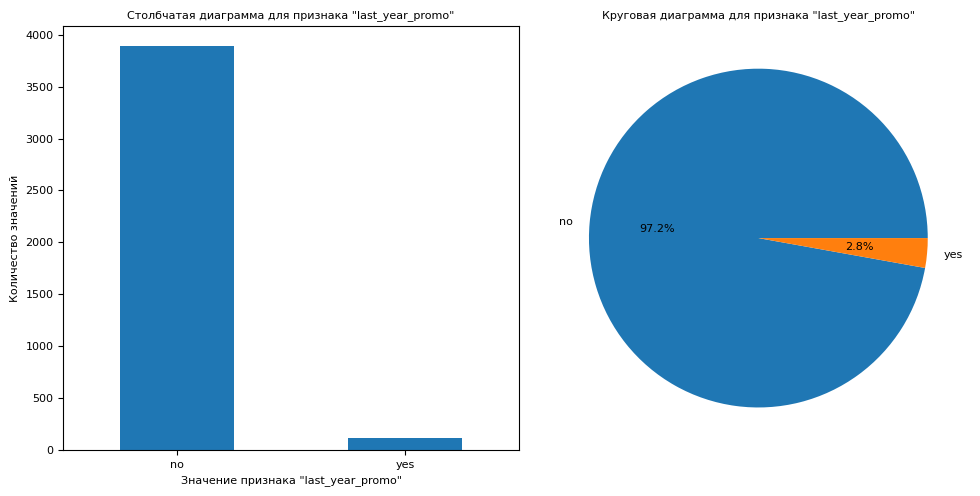

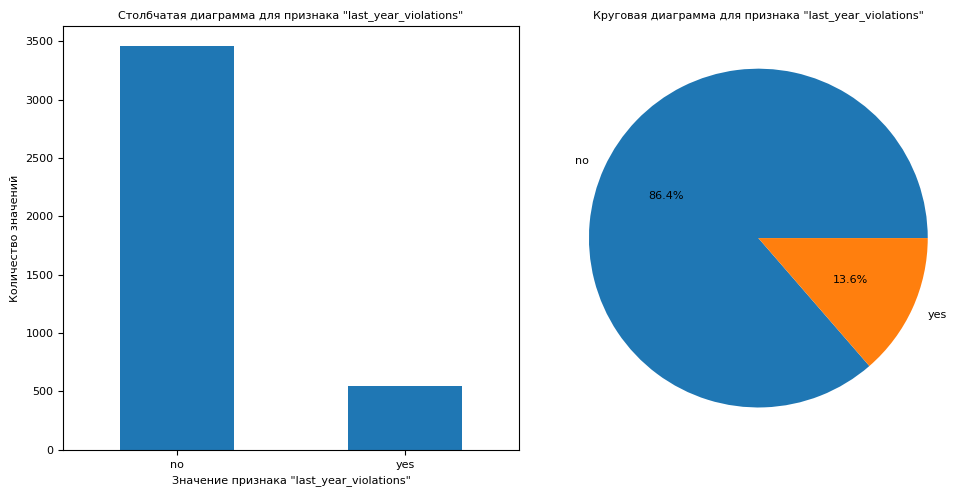

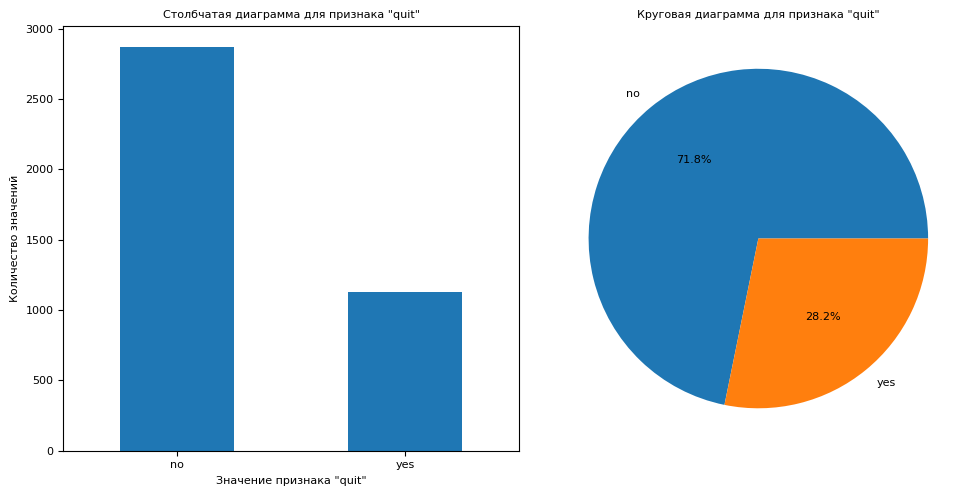

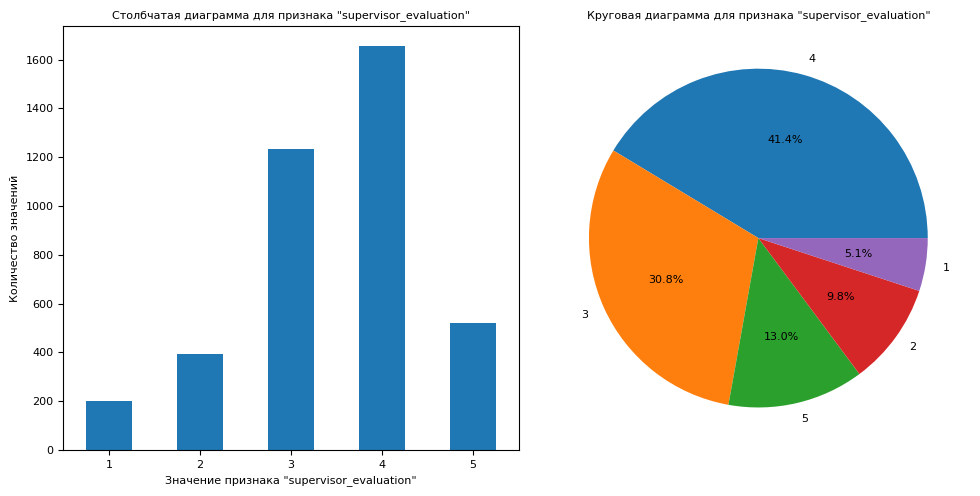

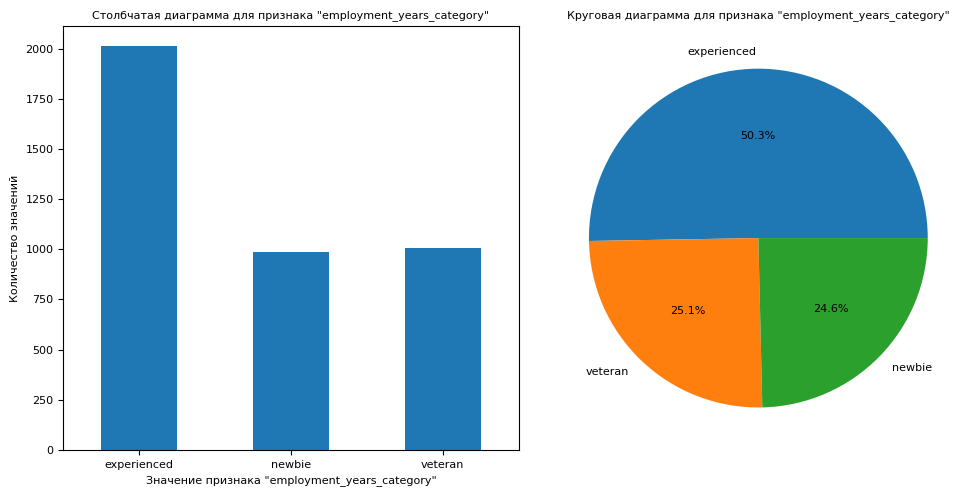

In [61]:
train_quit_num_names = train_quit_num.columns.to_list()
train_quit_cat_names = train_quit_cat.columns.to_list()

train_quit_num_names.remove('employment_years')
train_quit_num_names.remove('supervisor_evaluation')
train_quit_cat_names.append('supervisor_evaluation')
train_quit_cat_names.append('employment_years_category')

visualize_data(train_quit_copy, train_quit_num_names, train_quit_cat_names, font_size_delta=1)

##### Корреляционный анализ.

['salary']


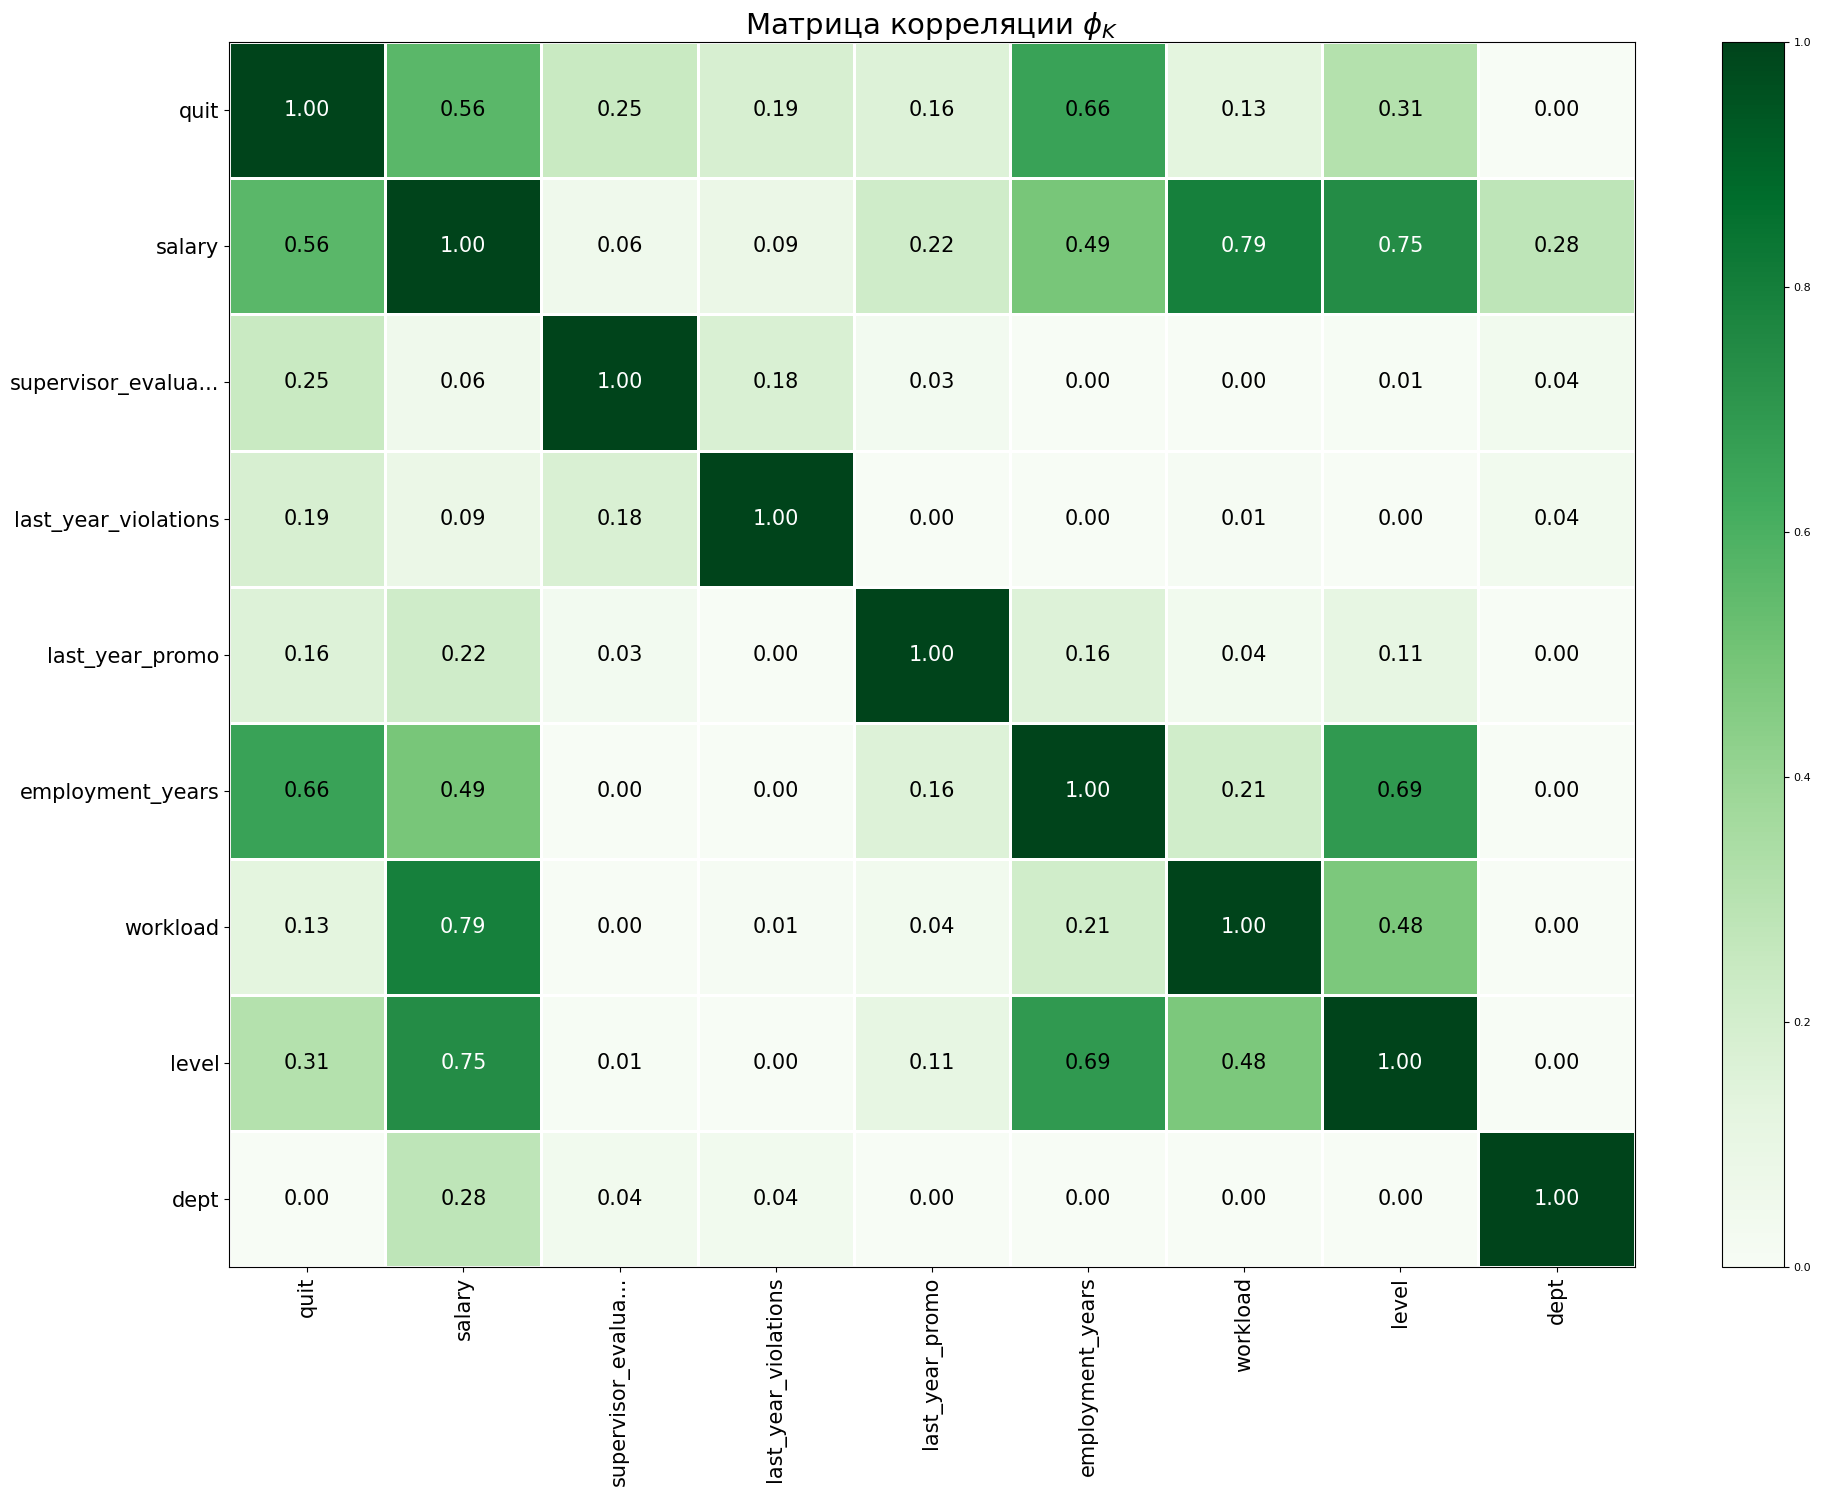

In [62]:
phik_matrix_display(train_quit)

В этой задаче так же будем опираться на шкалу Чеддока.

1. Между парами признаков (`salary`, `workload`) и (`salary`, `level`) имеется сильная связь. Заработная плата растет вместе с уровнем нагрузки и грейдом сотрудника, вполне логично;
2. Между парами признаков (`salary`, `quit`), (`employment_years`, `quit`) и (`employment_yearts`, `level`) имеется заметная связь. Судя по всему, зарплата и "выслуга" лет в компании — наиболее важные признаки при увольнении;
3. Между парами признаков (`employment_years`, `salary`), (`level`, `quit`) и (`level`, `workload`) имеется умеренная связь. Видимо массовые увольнения сотрудников с грейдом "junior" сильно влияют на показатель корреляции;
4. Мультиколлинеарности между признаками нет.

##### Выводы.

1. `salary`. Имеет нормально распределение со значительным смещением вправо. Большинство значений зарплат расположено в диапазоне от 20,000 до 40,000. Существует значительное число выбросов, что указывает на наличие некоторого количества очень высоких зарплат. Статистический анализ так же подтверждает, что есть серьезные разрывы между уровнем зарплат. 
2. `dept`. 35.9% сотрудников работают в отделе продаж, почти четверть (23.2%) — в техническом отделе, и по убыванию: закупки (14.7%), маркетинг (14.6%) и найм (11.6%);
3. `level`. Почти половина сотрудников (48.7%) имеет грейд `junior`. 42.4% — `middle` и лишь 8.9% имеет высокий уровень занимаемой должности. Это может говорить о перенасыщении относительно новыми сотрудниками, за которыми нужен дополнительный присмотр;
4. `workload`. Больше половины (53%) сотрудников имеют средний уровень загруженности, 30.2% — низкий и 16.9% — повышенный;
5. `last_year_promo`. 2.8% сотрудников получили повышение за последний год работы в компании;
6. `last_year_violations`. 13.6% сотрудников нарушали трудовой договор за последний год;
7. `supervisor_evaluation`. Руководители оценивают качество работы большей части сотрудников как выше среднего (показатель 4 — 41.4%) и среднее (показатель 3 — 30.8%). Наилучшую оценку от руководителя получили 13% сотрудников, наихудшую — 5.1%. И оценку 2 получило 9.8% работников;
8. `employment_years_category`. Половина сотрудников (50.3%) работает в компании от двух до пяти лет включительно. И примерно в равных долях распределены опытные сотрудники с более, чем пятилетним стажем (25.1%) и новички с опытом работы до года включительно (24.6)%;
9. `quit`. Наш целевой показатель: уволился сотрудник или нет. В наших данных доля уволившихся составляет 28.2%.

#### `test_target_quit`.

In [63]:
target_data = test_target_quit['quit'].value_counts()
target_data

no     1436
yes     564
Name: quit, dtype: int64

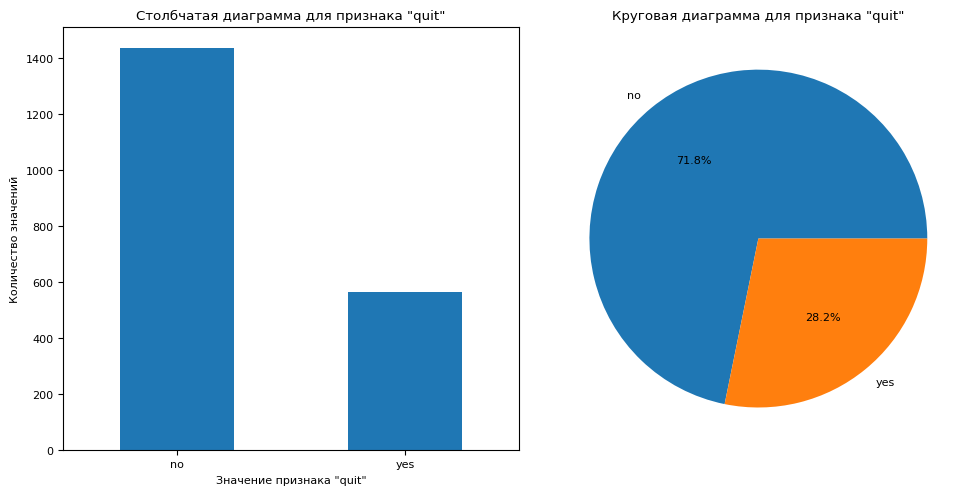

In [64]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
target_data.sort_index().plot(kind='bar')
plt.xticks(rotation=0)
plt.title(f'Столбчатая диаграмма для признака "quit"')
plt.xlabel(f'Значение признака "quit"')
plt.ylabel('Количество значений')

plt.subplot(1, 2, 2)
target_data.plot(kind='pie', autopct='%1.1f%%')
plt.title(f'Круговая диаграмма для признака "quit"')
plt.ylabel('')

plt.tight_layout()
plt.show()

##### Корреляционный анализ.

['salary']


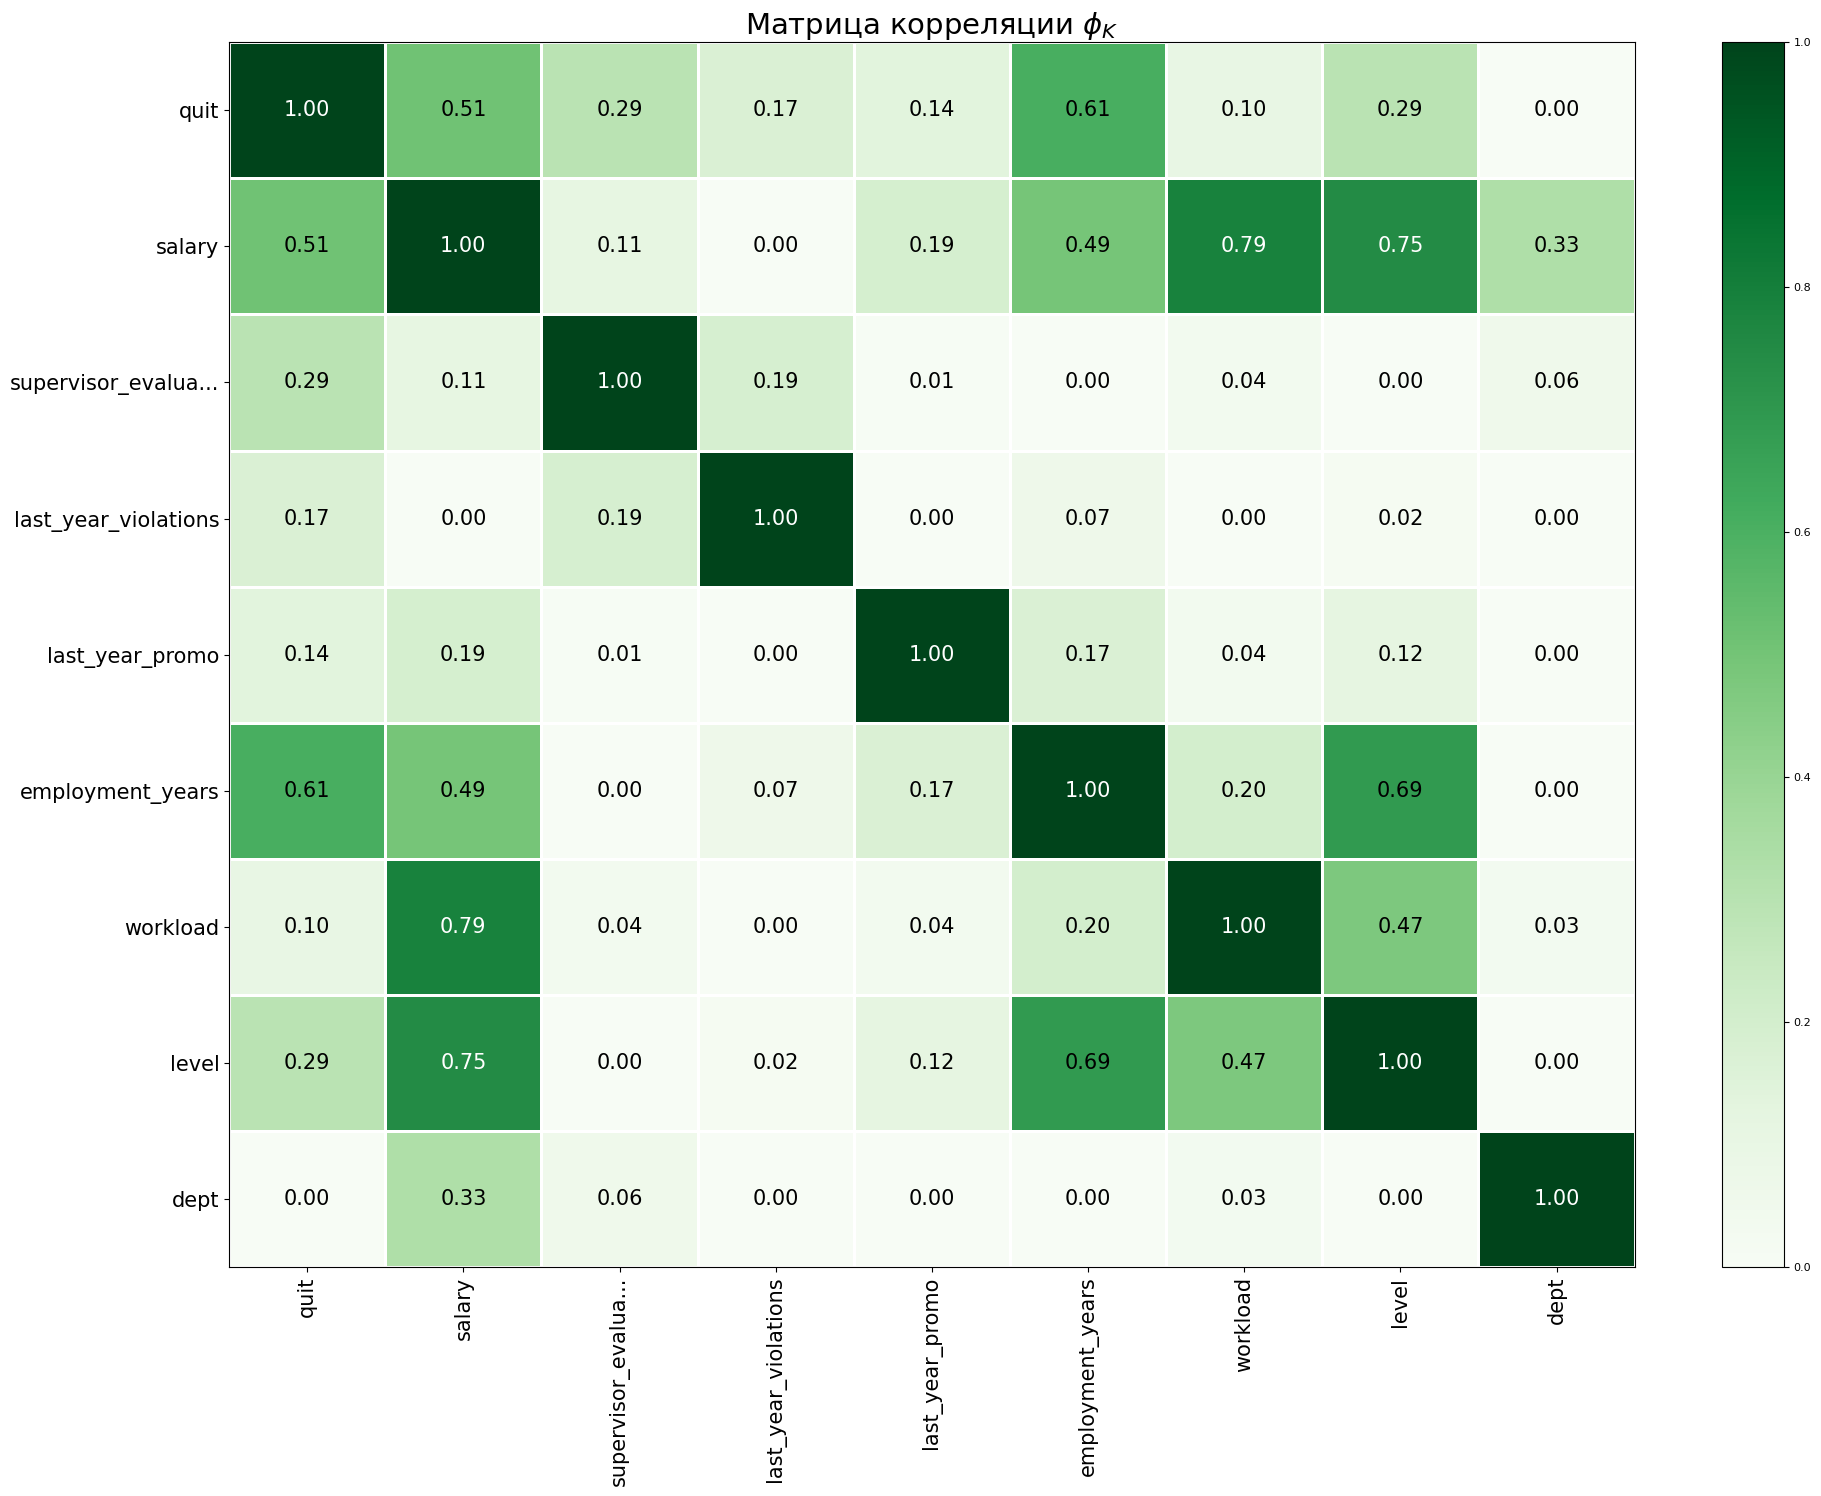

In [65]:
phik_matrix_display(test_features.merge(test_target_quit, on='id', how='left'))

Результаты один в один, с небольшим разбросом в несколько сотых по модулю, повторяют тренировочные данные, поэтому не будем на этом сильно зацикливаться. Мультиколлинеарности на тестовых данных так же нет.

##### Выводы.

1. `quit`. Доля уволившихся из компании сотрудников на тестовых данных — 28.2%.

#### Портрет уволившегося сотрудника.

Выделим типчиные характеристики для уволившегося сотрудника. Для этого сравним средние значения по каждому из признаков в разрезе целевого параметра `quit`.

<Figure size 800x600 with 0 Axes>

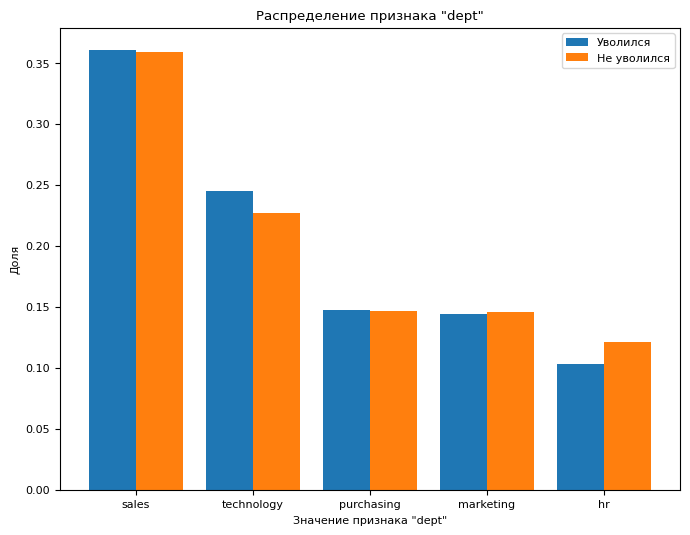

<Figure size 800x600 with 0 Axes>

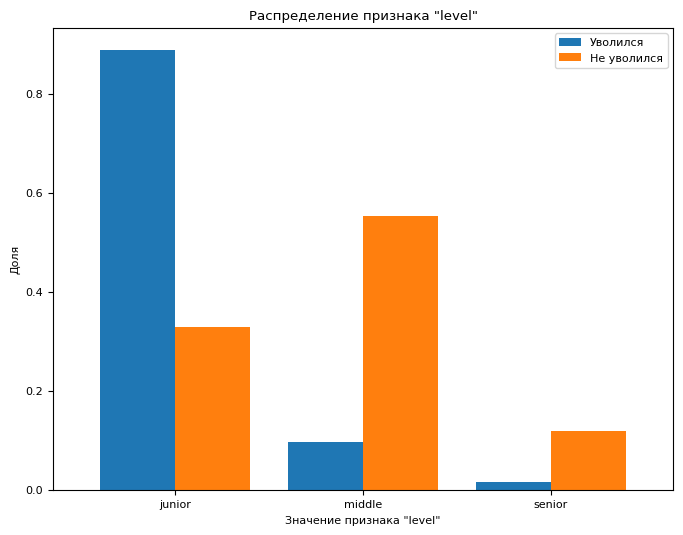

<Figure size 800x600 with 0 Axes>

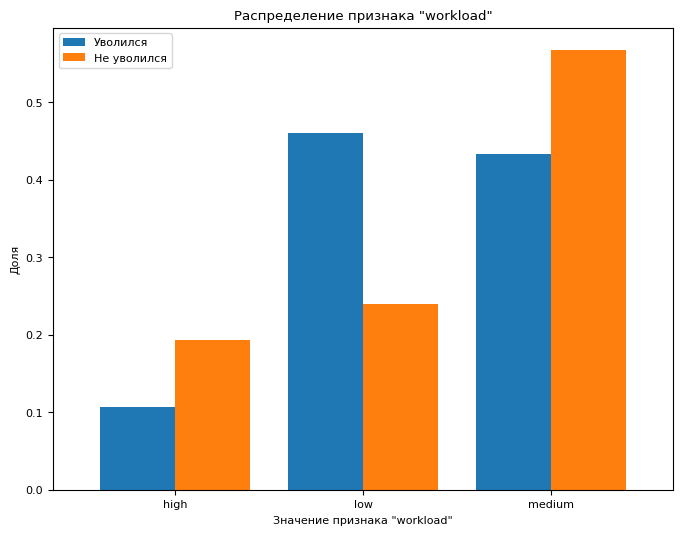

<Figure size 800x600 with 0 Axes>

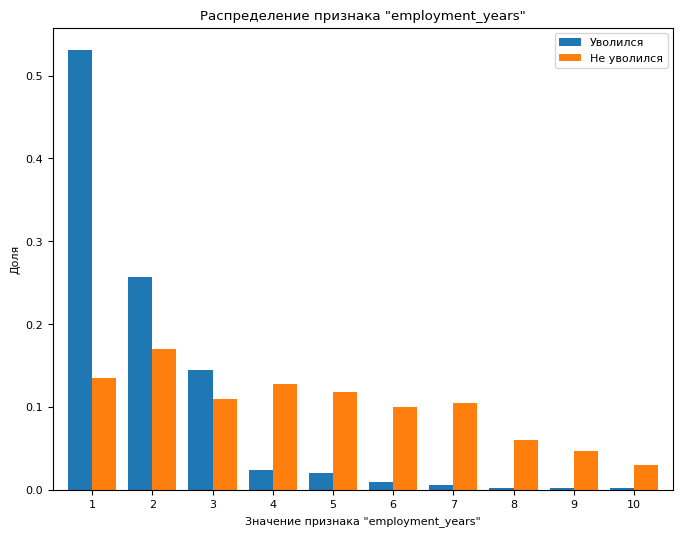

<Figure size 800x600 with 0 Axes>

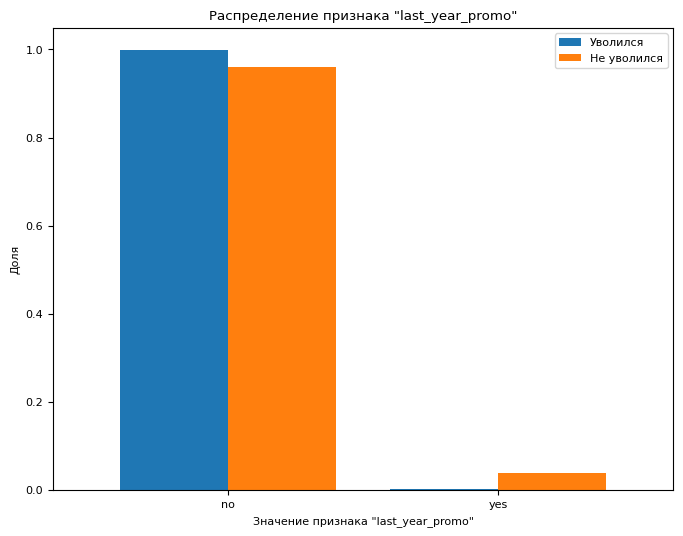

<Figure size 800x600 with 0 Axes>

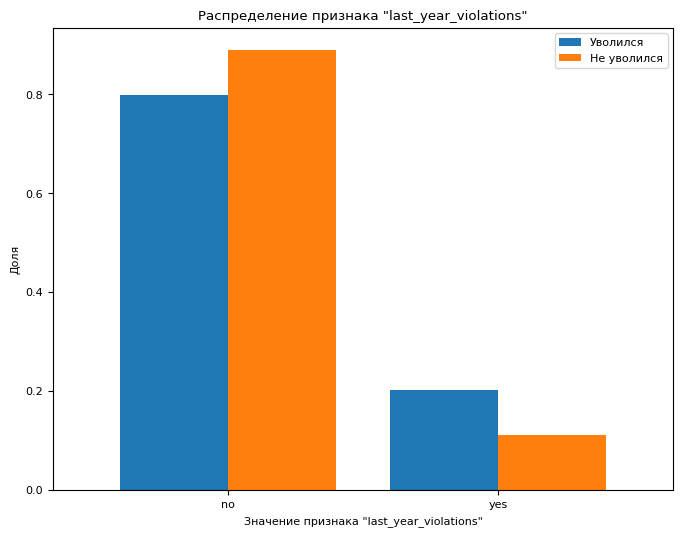

<Figure size 800x600 with 0 Axes>

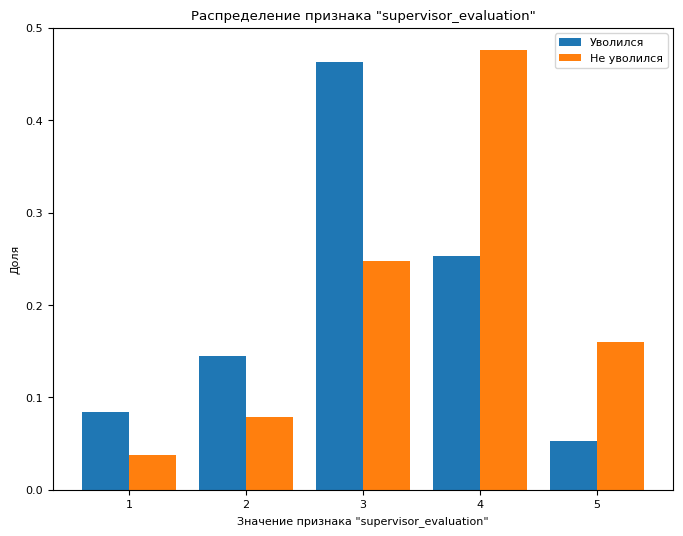

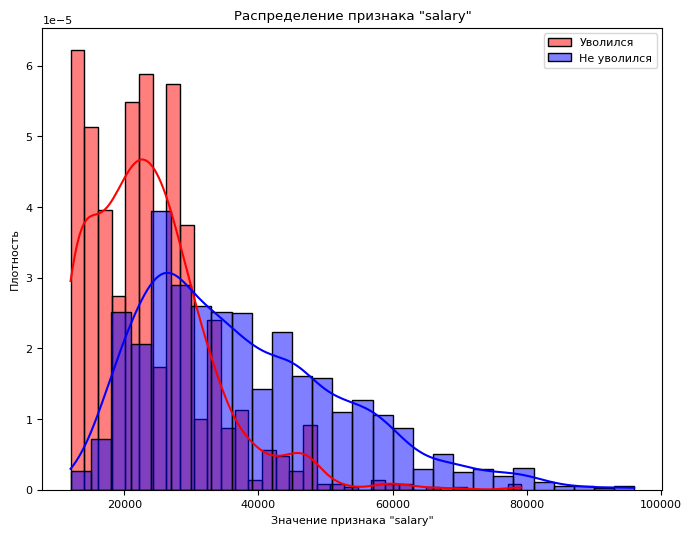

In [66]:
quit_yes = train_quit[train_quit['quit'] == 'yes']
quit_no = train_quit[train_quit['quit'] == 'no']

features_list = train_quit.drop(columns=['id', 'quit']).columns.to_list()

mean_values = {}
for feature in features_list:
    if train_quit[feature].dtype == 'object' or feature in ['supervisor_evaluation', 'employment_years']:
        mean_values[feature] = {
            'quit_yes': quit_yes[feature].value_counts(normalize=True),
            'quit_no': quit_no[feature].value_counts(normalize=True)
        }
    else:
        mean_values[feature] = {
            'quit_yes': quit_yes[feature].mean(),
            'quit_no': quit_no[feature].mean()
        }

def plot_numerical_feature(feature):
    plt.figure(figsize=(8, 6))
    sns.histplot(quit_yes[feature], color='red', label='Уволился', kde=True, stat="density")
    sns.histplot(quit_no[feature], color='blue', label='Не уволился', kde=True, stat="density")
    plt.title(f'Распределение признака "{feature}"')
    plt.xlabel(f'Значение признака "{feature}"')
    plt.ylabel('Плотность')
    plt.legend()
    plt.show()

def plot_categorical_feature(feature):
    plt.figure(figsize=(8, 6))
    yes_counts = mean_values[feature]['quit_yes']
    no_counts = mean_values[feature]['quit_no']
    data = pd.DataFrame({'Уволился': yes_counts, 'Не уволился': no_counts}).fillna(0)
    data.plot(kind='bar', figsize=(8, 6), width=0.8)
    plt.title(f'Распределение признака "{feature}"')
    plt.xlabel(f'Значение признака "{feature}"')
    plt.ylabel('Доля')
    plt.xticks(rotation=0)
    plt.show()

for feature in features_list:
    if train_quit[feature].dtype == 'object' or feature in ['supervisor_evaluation', 'employment_years']:
        plot_categorical_feature(feature)
    else:
        plot_numerical_feature(feature)

Так же отдельно сравним абсолютные показатели запрлат.

Средняя зарплата ушедших сотрудников: 23885.11
Средняя зарплата сотрудников, оставшихся в компании: 37702.23
Разница: 13817.12


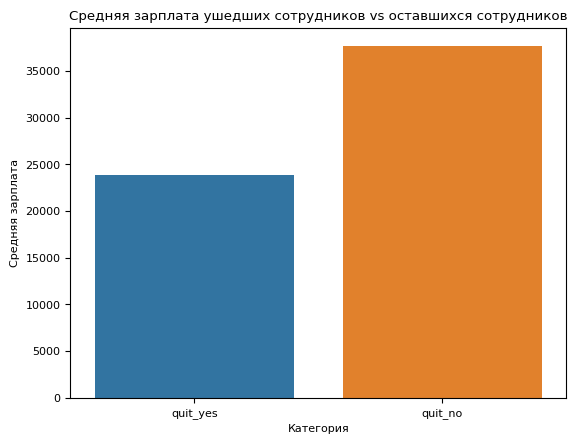

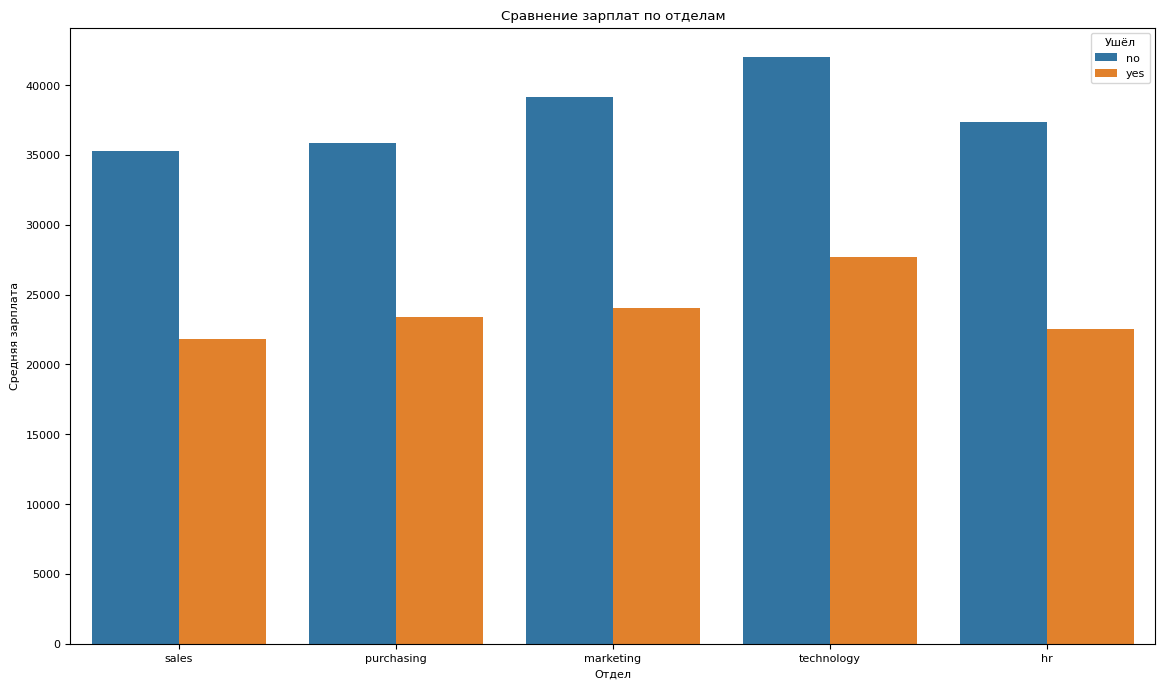

In [67]:
quit_yes = train_quit[train_quit['quit'] == 'yes']
quit_no = train_quit[train_quit['quit'] == 'no']
    
avg_salary_quit_yes = quit_yes['salary'].mean()
avg_salary_quit_no = quit_no['salary'].mean()

print(f'Средняя зарплата ушедших сотрудников: {avg_salary_quit_yes:.2f}')
print(f'Средняя зарплата сотрудников, оставшихся в компании: {avg_salary_quit_no:.2f}')
print(f'Разница: {abs(avg_salary_quit_no - avg_salary_quit_yes):.2f}')

avg_salaries = pd.DataFrame({
    'category': ['quit_yes', 'quit_no'],
    'average_salary': [avg_salary_quit_yes, avg_salary_quit_no]
})

sns.barplot(x='category', y='average_salary', data=avg_salaries)
plt.title('Средняя зарплата ушедших сотрудников vs оставшихся сотрудников')
plt.xlabel('Категория')
plt.ylabel('Средняя зарплата')
plt.show()

plt.figure(figsize=(14, 8))
sns.barplot(x='dept', y='salary', hue='quit', data=train_quit, ci=None)
plt.title('Сравнение зарплат по отделам')
plt.xlabel('Отдел')
plt.ylabel('Средняя зарплата')
plt.legend(title='Ушёл')
plt.show()

Зарплата тех, кто ушел из компании, в среднем, почти на 14 тысяч меньше тех, кто до сих пор работает в ней. Довольно интересный результат. Такой разброс, скорее всего, вызван тем, что большинство уволившихся, как мы установили, — сотрудники с грейдом "junior", имеющие довольно низкую зарплатную вилку. А сотрудники с более высокой должностью остаются в компании на длительный период. Отсюда и такой сильный разброс.

Больше всего получают, в среднем, в технологическом отделе, меньше всего — в продажах. 

##### Выводы.

1. `dept`. Во всех отделах равные доли между теми, кто уволился из компании и теми, кто до сих пор работает в ней. Может быть это особенность конкретно нашей выборки. Небольшой перевес в пользу уволившихся наблюдается в техническом отделе. Возьмем для нашего портрета именно его;
2. `level`. Невооруженным взглядом видно, что большинство увольнений приходится на сотрудников с грейдом "junior". Судя по этим результатам, начинающие специалисты надолго не задерживаются в компании;
3. `workload`. По доле увольнений лидирует категория сотрудников, которые имеют низкий уровень рабочей нагрузки. Тяжело сказать, вазвано ли это недоверием со стороны руководства или просто отсутствием каких-либо рабочих амбиций и желанием брать дополнительную ответственность;
4. `employment_years`. Почти все увольнения происходят в первые три года работы сотрудника в компании. Лидирует в разрезе целевого признака, первый год трудойстройства, который, судя по статистике, становится последним для большого числа сотрудников;
5. `last_year_promo`. Если сотрудника повышали за последний год, он, как правило, не увольняется;
6. `last_year_violations`. Если сотрудник нарушал условия трудового договора за последний год, то почти в 2/3 случаев, он, в последствии, увольняется;
7. `supervisor_evaluation`. Доля уволившихся сотрудников превышает долю оставшихся во всех случаях, когда руководитель оценивает работу сотрудника от 1 до 3 (от совсем плохо до удовлетворительно). Можно предположить, что руководитель в данном случае сам, своего рода модель, которая, судя по статстике, довольно эффективно предугадывает кто уволится, а кто нет;
8. `salary`. Ожидаемый результат: пиковая доля уволившихся сотрудников находится в окрестностях самых низких зарплат. Наибольшее количество увольнений приходится на сотрудников с запралатой от 20 до 25 тысяч. Для большинства сотрудников зарплата — основная мотивация, что довольно логично. Начиная где-то с 30 тысяч, доля уволившихся сотрудников довольно резко снижается: людей устривает этот уровень дохода и они все меньше хотят менять текущее место работы;
9. Зарплата тех, кто ушел из компании, в среднем, на 14 тысяч меньше тех, кто до сих пор работает в ней. Больше всего получают, в среднем, в технологическом отделе, меньше всего — в продажах. 

Целевой потрет — сотрудник из технического с опытом работы до года включительно, грейд "junior", низкая рабочая загруженность. Не было повышений за последний год, но были нарушения трудового договора. Оценка руководителя от 1 до 3, зарплата 20-25 тысяч в месяц.

#### Сравнение распределения признака удовлетворенности сотрудника для уволившихся и оставшихся сотрудников.

Аналитики утверждают, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Добавим признак `job_satisfaction_rate` из тестовых данных к датасету для этой задачи и проверим утверждение аналитиков.

In [68]:
test_data = test_data.merge(test_target_quit, on='id', how='left')
test_data['quit'].isna().sum()

0

Для анализа уровня удовлетворенности работой среди сотрудников, которые ушли из компании, и тех, которые остались, будем использовать визуализацию распределений и статистический тест. Визуализация поможет наглядно увидеть различия между группами, а статистический тест позволит количественно оценить эти различия.

Сформулируем нулевую и альтенативную гипотезы для нашего теста.

$H_0: \mu_{yes} = \mu_{no}$

$H_1: \mu_{yes} \neq \mu_{no}$

Или, если говорить менее формально, то нулевая гипотеза предполагает, что нет различий в распределении уровня удовлетворенности работой между двумя группами сотрудников, а альтернативная гипотеза наоборот, предполагает, что существуют различия в распределении уровня удовлетворенности работой между двумя группами сотрудников.

У нас имеется две независимые выборки, поэтому для проверки гипотезы будем использовать метод из библиотеки `scipy`: `scipy.stats.ttest_ind`.

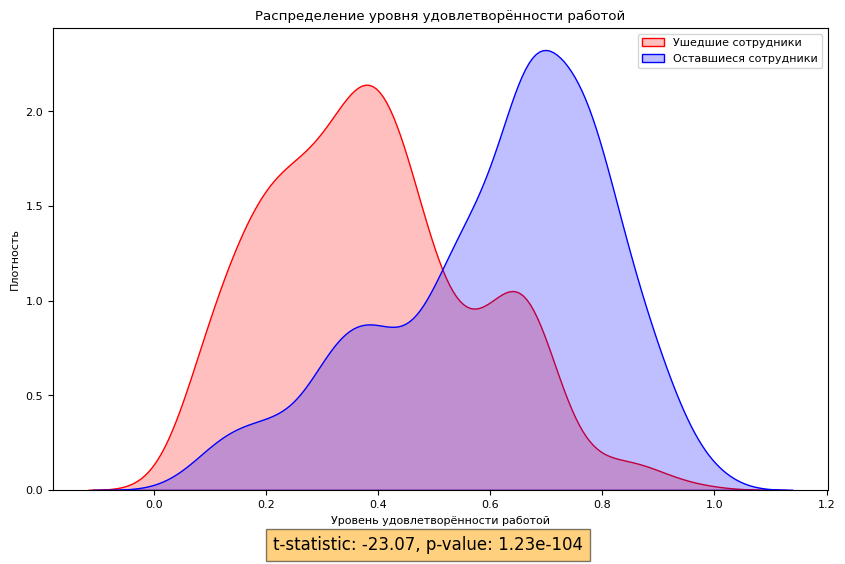

In [69]:
quit_yes = test_data[test_data['quit'] == 'yes']
quit_no = test_data[test_data['quit'] == 'no']

t_stat, p_value = ttest_ind(quit_yes['job_satisfaction_rate'], quit_no['job_satisfaction_rate'])

plt.figure(figsize=(10, 6))
sns.kdeplot(quit_yes['job_satisfaction_rate'], label='Ушедшие сотрудники', shade=True, color='red')
sns.kdeplot(quit_no['job_satisfaction_rate'], label='Оставшиеся сотрудники', shade=True, color='blue')
plt.title('Распределение уровня удовлетворённости работой')
plt.xlabel('Уровень удовлетворённости работой')
plt.ylabel('Плотность')
plt.legend()

plt.figtext(
    0.5,
    0.01,
    f't-statistic: {t_stat:.2f}, p-value: {p_value:.2e}',
    ha='center',
    fontsize=12,
    bbox={"facecolor": "orange", "alpha": 0.5, "pad": 5}
)

plt.show()

$t-statistic = -23.07$ — это значение показывает, насколько сильно различаются средние значения уровней удовлетворенности работой между двумя группами (ушедшими и оставшимися сотрудниками). В данном случае, значение t-статистики далеко от нуля, что указывает на значительное различие между средними значениями двух групп.

Принимая во внимание очень малое p-значение, мы **отвергаем нулевую гипотезу** в пользу альтернативной гипотезы. Это означает, что существует статистически значимая разница в уровне удовлетворенности работой между сотрудниками, которые ушли из компании, и теми, которые остались. Средний уровень удовлетворенности работой среди ушедших сотрудников значительно ниже.

### Добавление нового входного признака

Добавим предсказания уровня удовлетворенности сотрудников к нашим тренировочным данным. Для этого воспользуемся лучшей моделью из первой задачи.

In [70]:
train_quit_filtered = train_quit.drop(columns=['id', 'quit'])
predictions_train = best_model.predict(train_quit_filtered).round(2)
train_quit['predicted_job_rate'] = pd.Series(predictions_train, index=train_quit_filtered.index)
train_quit.head(10)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,predicted_job_rate
0,723290,sales,middle,high,2,no,no,4,54000,no,0.63
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.84
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.39
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.33
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.80
5,699916,sales,junior,low,1,no,yes,3,18000,yes,0.12
6,417070,technology,middle,medium,8,no,no,2,44400,no,0.40
7,165489,sales,middle,low,4,no,no,5,19200,no,0.48
8,996399,marketing,middle,low,7,no,no,4,25200,no,0.82
9,613206,technology,middle,medium,2,no,no,3,45600,yes,0.33


In [71]:
test_features_filtred = test_features.drop(columns=['id'])
predictions_test = best_model.predict(test_features_filtred).round(2)
test_features['predicted_job_rate'] = pd.Series(predictions_test, index=test_features_filtred.index)
test_features.head(10)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,predicted_job_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,0.86
1,686555,hr,junior,medium,1,no,no,4,30000,0.68
2,467458,sales,middle,low,5,no,no,4,19200,0.69
3,418655,sales,middle,low,6,no,no,4,19200,0.68
4,789145,hr,middle,medium,5,no,no,5,40800,0.82
5,429973,purchasing,middle,medium,6,no,no,3,42000,0.64
6,850699,technology,junior,medium,3,no,no,3,26400,0.33
7,500791,sales,middle,high,9,no,no,4,49200,0.67
8,767867,marketing,middle,high,3,no,yes,4,62400,0.49
9,937235,sales,junior,medium,1,no,yes,3,26400,0.17


### Подготовка данных

#### Пайплайн предобработки и подготовки.

В общем и целом, алгоритм предобработки и подготовки не поменялся. Мы используем те же признаки, что и при выполнении первой задачи. Переиспользуем код предыдущей задачи и возьмем её этапы пайплайна преобработки и подготовки.

In [72]:
second_num_columns = ['salary', 'employment_years', 'predicted_job_rate']


second_ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='unknown')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='infrequent_if_exist', sparse_output=False))
    ]
)

second_data_preprocessor = ColumnTransformer(
    [
        ('num', StandardScaler(), second_num_columns),
        ('ohe', second_ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns)
    ],
    remainder='passthrough'
)

### Обучение моделей

#### Пайплайн обучения моделей.

По аналогии первой задачи, будем обучать модели в пайплайне. 

Для решения задачи классификации возьмем следующий список моделей: логистическая регрессия, опорных векторов, дерево решений, ближайших соседей и случайный лес. Переберем несколько гипепараметров для поиска наилучшего варианта.

В качестве метрики оценки качества в данной задаче возьмем `ROC-AUC`.

Критерием успеха для задачи будет $ROC-AUC \geq 0.91$ на тестовой выборке. 

Как и в первой задаче, удалим уникальный идентификатор пользователя, чтобы не передавать модели одинаковые данные.

In [73]:
X_second = train_quit.drop(columns=['id'])

In [74]:
if X_second.duplicated().sum() > 0:
    X_second = X_second.drop_duplicates()

y_second = X_second['quit']    
X_second = X_second.drop(columns=['quit'])

In [75]:
label_encoder = LabelEncoder()
y_second_encoded = label_encoder.fit_transform(y_second)

if set(label_encoder.classes_) == {'no', 'yes'}:
    yes_index = list(label_encoder.classes_).index('yes')
    no_index = list(label_encoder.classes_).index('no')
    
    classes = label_encoder.classes_.copy()
    classes[yes_index], classes[no_index] = classes[no_index], classes[yes_index]

    label_encoder = LabelEncoder()
    label_encoder.classes_ = classes
    y_second_encoded = label_encoder.transform(y_second)

second_pipe_final = Pipeline([
    ('preprocessor', second_data_preprocessor),
    ('model', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

second_param_grid = [
    {
        'model': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'model__max_depth': range(2, 10),
        'model__min_samples_split': range(2, 10),
        'model__min_samples_leaf': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    {
        'model': [KNeighborsClassifier()],
        'model__n_neighbors': range(2, 25),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    {
        'model': [LogisticRegression(random_state=RANDOM_STATE, solver='saga')],
        'model__penalty': ['l1', 'l2', 'elasticnet', None],
        'model__l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    {
        'model': [SVC(random_state=RANDOM_STATE, probability=True)],
        'model__kernel': ['linear', 'rbf', 'sigmoid'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    {
        'model': [SVC(random_state=RANDOM_STATE, probability=True)],
        'model__kernel': ['poly'],
        'model__degree': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    
    {
        'model': [RandomForestClassifier(random_state=RANDOM_STATE)],
        'model__n_estimators': [10, 50, 100, 150, 200],
        'model__criterion': ['gini', 'entropy'],
        'model__max_depth': range(2, 25),
        'model__min_samples_split': range(2, 25),
        'model__min_samples_leaf': range(2, 25),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

second_randomized_search = RandomizedSearchCV(
    second_pipe_final,
    second_param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    n_iter=200,
    random_state=RANDOM_STATE
)

In [76]:
second_randomized_search.fit(X_second, y_second_encoded)

print('Лучшая модель и её параметры:\n\n', second_randomized_search.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', round(second_randomized_search.best_score_, 2))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  ['salary', 'employment_years',
                                                   'predicted_job_rate']),
                                                 ('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(fill_value='unknown',
                                                                                 strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='infrequent_if_exist',
      

Лучшая модель, так же как и в прошлой задаче, — случайный лес. Показатель $ROC-AUC = 0.92$ на кросс-валидации.

Возьмем лучшую модель и получим предсказания для тестовой выборки.

In [77]:
X_test_second = test_data.drop(columns=['id', 'quit']).rename(columns={'job_satisfaction_rate': 'predicted_job_rate'})
y_test_second = test_data['quit']

y_test_encoded = label_encoder.transform(y_test_second)

y_test_pred_proba = second_randomized_search.best_estimator_.predict_proba(X_test_second)[:, 1]
roc_auc = roc_auc_score(y_test_encoded, y_test_pred_proba)

print(f'ROC-AUC на тестовой выборке: {roc_auc:.2f}')

ROC-AUC на тестовой выборке: 0.93


Критерий успеха достигнут. Довольно хорошее качество на тестовых данных.

Сравним модель со случайными предсказаниями.

In [78]:
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X_second, y_second_encoded)

dummy_score = cross_val_score(dummy_clf, X_second, y_second_encoded, cv=5, scoring='roc_auc').mean()

print('Метрика ROC-AUC на кросс-валидации Dummy-модели:', round(dummy_score, 2))

Метрика ROC-AUC на кросс-валидации Dummy-модели: 0.5


$ROC-AUC = 0.5$ — отличительная черта модели, выдающей случайные предсказания. Успех.

#### Анализ важности признаков.

100%|===================| 3995/4000 [00:38<00:00]        

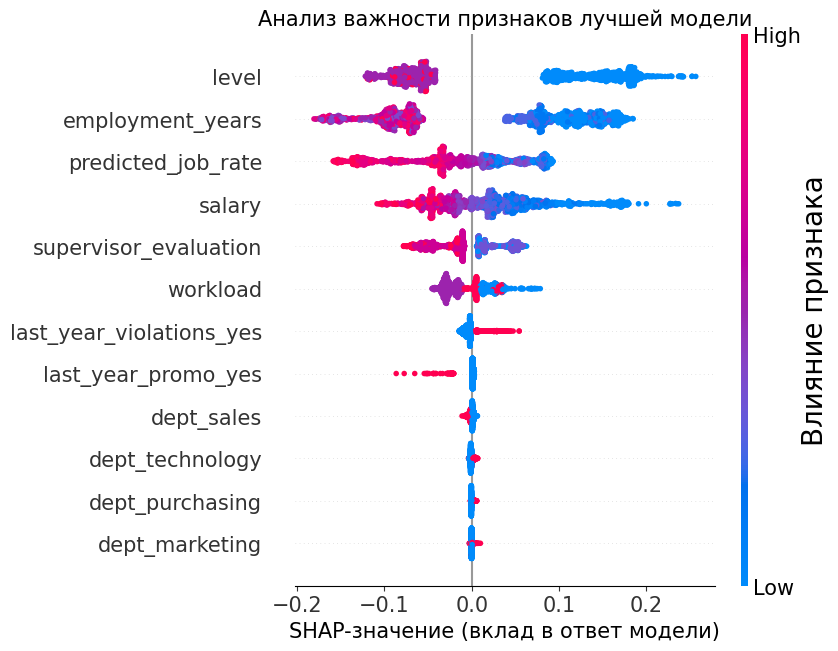

In [79]:
best_rfc_model = second_randomized_search.best_estimator_
rfc_model_steps = best_rfc_model.named_steps['model']
rfc_preprocessor = best_rfc_model.named_steps['preprocessor']
X_train_transformed_second = rfc_preprocessor.transform(X_second)
X_test_transformed_second = rfc_preprocessor.transform(X_test_second)
feature_names_second = rfc_preprocessor.get_feature_names_out()
feature_names_second = [name[5:] for name in feature_names_second]

explainer_second = shap.Explainer(rfc_model_steps, X_train_transformed_second)
shap_values_second = explainer_second(X_test_transformed_second, check_additivity=False)

shap_values_second_array = shap_values_second.values
if shap_values_second_array.shape[-1] != 1:
    shap_values_second_array = shap_values_second_array[..., 0]

shap.summary_plot(shap_values_second_array, X_test_transformed_second, feature_names=feature_names_second, show=False)

fig, ax = plt.gcf(), plt.gca()

ax.tick_params(labelsize=15)
ax.set_xlabel('SHAP-значение (вклад в ответ модели)', fontsize=15)
ax.set_title('Анализ важности признаков лучшей модели', fontsize=15)

cb_ax = fig.axes[1] 

cb_ax.tick_params(labelsize=15)
cb_ax.set_ylabel('Влияние признака', fontsize=20)

plt.show()

PermutationExplainer explainer: 201it [01:51,  1.63it/s]                         


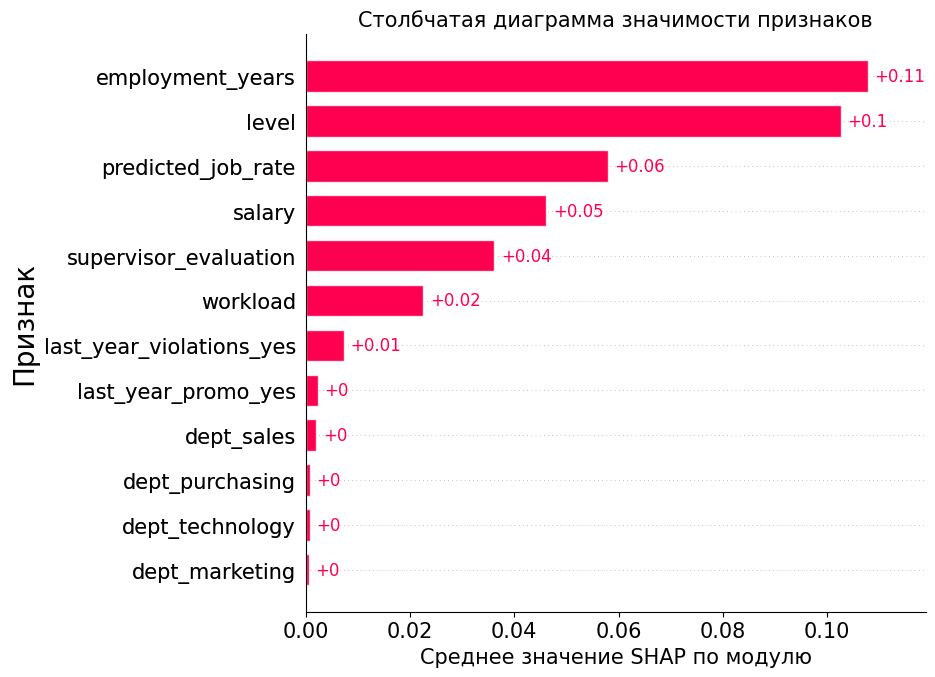

In [80]:
SAMPLE_SIZE = 200

another_train_sample = shap.sample(X_train_transformed_second, SAMPLE_SIZE, random_state=RANDOM_STATE)
another_test_sample = shap.sample(X_test_transformed_second, SAMPLE_SIZE, random_state=RANDOM_STATE)

def model_predict(X):
    return rfc_model_steps.predict_proba(X)[:, 1] 

explainer = shap.Explainer(model_predict, another_train_sample, feature_names=feature_names_second)

shap_values = explainer(another_test_sample)

shap.plots.bar(shap_values, max_display=len(feature_names_second), show=False)

ax = plt.gca()

ax.tick_params(labelsize=15)
ax.set_xlabel('Среднее значение SHAP по модулю', fontsize=15)
ax.set_title('Столбчатая диаграмма значимости признаков', fontsize=15)
ax.set_ylabel('Признак', fontsize=20)

plt.show()

#### Выводы.

1. Для решения задачи классификации мы попробовали пять различных моделей с целью найти наилучшую;
2. Для каждой модели мы попробовали подобрать оптимальный набор гиперпараметров;
3. Лучшей моделью после кросс-валидации стал случайный лес;
4. Показатель метрики $ROC-AUC$ на тестовой выборке составил $0.92$, что является хорошим результатом;
5. Наиболее важные признаками для модели стали `level` (уровень занимаемой должности), `employment_years` (длительность трудойстройства в годах) и `predicted_job_rate` (уровень удовлетворенности сотрудника);
6. Наименее важными признаками для модели — отдел, в котором находится сотрудник, и факт повышения за последний год.

### Выводы

В рамках второй задачи нам необходимо было решить задачу классификации, которая бы могла предсказывать, уволится ли сотрудник из компании. Это позволит в дальнейшем качественнее оптимизировать рабочие процессы и снизить кадровую текучесть.

Лучше всего, по показателю метрики `ROC-AUC`, с поставленной задачей справилась модель случайного леса с качеством на тестовой выборке $= 0.93$. Наиболее важными для модели признаками являются уровень занимаемой должности, длительность трудоустройства в годах и уровень удовлетворенности работой в компании сотрудника.

## Общий вывод

В рамках проекта нам необходимо было решить две крупных задачи: первой была задача прогнозирования уровня удовлетворенности работой в компанией сотрудником, второй — предсказание потенциального увольнения сотрудника. Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник. 

Сформулируем выводы отдельно по каждому разделу:

###### Задача 1: предсказание уровня удовлетворённости сотрудника
**Преодоработка данных**

В пределах задачи у нас был тестовый датасет с 4 тысячами записей, в которых содержалась информация о бывших и нынешних сотрудниках компании. Заказчик ответственно подошел к формированию данных в вопросе разметки и содержимого. В данных содержались единичные пропуски в столбцах `level`, `dept` и `workload`. Стоит уведомить об этом заказчика, это может быть вызвано техническим сбоем. Так же в столбцах есть неявные пропуски в виде символов пробела. Об этом так же стоит упомянуть.


**Исследовательский анализ данных**
1. Большинство сотрудников получает от 20 до 40 тысяч в месяц;
2. Распределение походит на бимодальное с пиками в окрестностях 0.4 и 0.6. Пик в окрестности 0.4 свидетельствует о том, что заметная часть сотрудников оценивает свою удовлетворенность работой чуть ниже среднего уровня. И наоборот, пик в окрестностях 0.6 говорит, что многие сотрудники оценивают свою удовлетворенность работой немного выше среднего уровня. Минимальное значение в 0.03 свидетельствуют о том, что есть сотрудники, которых абсолютно не устраивает работа в компании;
3. Больше трети сотрудников (37.2%) работают в департаменте продаж, пятая часть — в техническом отделе (21.7%) и по убыванию: закупки (15.3%), маркетинг (13.8%) и найм (11.4%);
4. Почти половина сотрудников (47.4%) имеет грейд junior. 43.6% — middle и лишь 9% имеет высокий уровень занимаемой должности. Это может говорить о перенасыщении сотрудниками-новичками, за которыми нужен дополнительный присмотр;
5. Чуть больше половины сотрудников имеют средний уровень загруженности, 30% — низкий и 18.4% — повышенный;
6. Лишь 3% сотрудников получили повышение в этом году. В компании явно стараются лишний раз не повышать сотрудников. Это может сильно влиять на уровень удовлетворенности;
7. 14% сотрудников нарушали трудовой договор за последний год;
8. Руководители оценивают качество работы большей части сотрудников как среднее (показатель 3 — 31.6%) и выше среднего (показатель 4 — 40.1%). Наилучшую оценку от руководителя получили 13.7% сотрудников, наихудшую — 5%. И оценку 2 получило 9.7% работников;
9. Половина сотрудников (50.8%) работает в компании от двух до пяти лет включительно. И примерно в равных долях распределены опытные сотрудники с более, чем пятилетним стажем (25%) и новички с опытом работы до года включительно (24.2)%;
10. Тестовые данные почти в точности повторяют тренировочные. Явных выбросов и отклонений в данных нет.

**Подготовка данных**

Была проведена дополнительная подготовка данных: масштабирование количественных и кодирование категориальных признаков. 

Мультиколлинеарности в данных нет.

Признак зарплаты сотрудника имеет слабую зависимость от количества лет работы в компании.

**Обучение моделей**

1. Мы обучили пять различных моделей машинного обучения с целью поиска наилучшей для нашего кейса;
2. Мы применили RandomizedSearchCV для подбора оптимальных гиперпараметров моделей, используя настраиваемую метрику SMAPE (Symmetric Mean Absolute Percentage Error) для оценки моделей;
3. Лучшей моделью по результатам кросс-валидации стала модель случайного леса;
4. Итоговый показатель метрики $SMAPE$ лучшей модели на тестовой выборке — $12.78$;
5. Модель достаточно хорошо обобщает данные и не имеет признаков переобучения: качество на тестовой выборке выше, чем на тренировочной и валидационной;
5. Наиболее важными для модели стали признаки: оценка со стороны руководства, срок работы в компании, грейд и зарплата сотрудника. Эта информация может быть полезна заказчику, если он хочет в дальнейшем влиять на показатель удовлетворенности;
6. Наименее важные признаки — отдел и булево значение: было ли повышение у сотрудника за последний год или нет.

###### Задача 2: предсказание увольнения сотрудника из компании
**Преодоработка данных**

Заказчик, так же как и для предыдущей задачи, предоставил 4 тысячи записей о бывших и нынешних сотрудниках компании. Данные не содержат пропусков, дубликатов, выбросов и аномалий. 

**Исследовательский анализ данных**

Распределения значений во многом повторяют предыдущую выборку: схожий уровень зарплат, процентное соотношение сотрудников в отделе, грейду, рабочей загрузки и другим признакам. 

Дополнительно нам был предоставлен признак `quit` — уволился ли сотрудник или нет. В выборке доля уволившихся составила 28.2%.

Отдельно опишем результаты сравнения средних показателей тех, кто уволился из компании и тех, кто до сих пор работает.

1. Во всех отделах равные доли между теми, кто уволился из компании и теми, кто до сих пор работает в ней. Может быть это особенность конкретно нашей выборки. Небольшой перевес в пользу уволившихся наблюдается в техническом отделе;
2. Большинство увольнений приходится на сотрудников с грейдом "junior". Судя по этим результатам, начинающие специалисты надолго не задерживаются в компании;
3. По доле увольнений лидирует категория сотрудников, которые имеют низкий уровень рабочей нагрузки. Это может быть сигналом заказчик, поскольку можно предположить, что такое распределение вазвано недоверием со стороны руководства или просто отсутствием каких-либо рабочих амбиций и желанием брать дополнительную ответственность отдельным сотрудником;
4. Большая часть сотрудников увольняется до того момента, как они отработают три полных года в компании;
5. Если сотрудника повышали за последний год, он, как правило, не увольняется;
6. Если сотрудник нарушал условия трудового договора за последний год, то почти в 2/3 случаев, он, в последствии, увольняется;
7. Доля уволившихся сотрудников превышает долю оставшихся во всех случаях, когда руководитель оценивает работу сотрудника от 1 до 3 (от "очень плохо" до "удовлетворительно");
8. Пиковая доля уволившихся сотрудников находится в окрестностях самых низких зарплат. Наибольшее количество увольнений приходится на сотрудников с запралатой от 20 до 25 тысяч. Для большинства сотрудников зарплата — основная мотивация, что довольно логично. Начиная где-то с 30 тысяч, доля уволившихся сотрудников довольно резко снижается: людей устривает этот уровень дохода и они все меньше хотят менять текущее место работы;
9. Существует статистически значимая разница в уровне удовлетворенности работой между сотрудниками, которые ушли из компании, и теми, которые остались. Средний уровень удовлетворенности работой среди ушедших сотрудников значительно ниже;
10. Зарплата тех сотрудников, кто ушел из компании, в среднем, почти на 14 тысяч меньше тех, кто до сих пор работает в ней. Больше всего получают, в среднем, в технологическом отделе, меньше всего — в продажах.

Потрет уволившегося сотрудника: из технического отдела с опытом работы до года включительно, грейд "junior", низкая рабочая загруженность. Не было повышений за последний год, но были нарушения трудового договора. Оценка руководителя от 1 до 3, зарплата 20-25 тысяч в месяц.

График и показатели статистического анализа указывают на значительное отличие в уровнях удовлетворенности работой между ушедшими и оставшимися сотрудниками. В среднем, ушедшие сотрудники имели значительно более низкий уровень удовлетворенности работой по сравнению с теми, кто остался в компании. Эти результаты могут служить важным индикатором для управления и улучшения внутренних процессов и условий труда в компании.

**Подготовка данных**

Мы переиспользовали код из предыдущей задачи для формирования пайплайна преобработки и подготовки.

Между признаками `salary`, `job_satisfaction_rate` и `employment_years` наблюдается умеренно-слабый уровень корреляции. В свою очередь, между признаками `job_satisfaction_rate` и `supervisor_evaluation` высокий коэффициент корреляции. 

Мультиколлинеарности между признаками нет.

**Обучение моделей**

1. Мы обучили пять различных моделей машинного обучения с целью поиска наилучшей для нашего кейса;
2. Мы применили RandomizedSearchCV для подбора оптимальных гиперпараметров моделей, используя метрику $ROC-AUC$ для оценки моделей;
3. Качество модели на тестовой выборке — $ROC-AUC = 0.92$, что является хорошим показателем и отвечает критерию успеха заказчика;
4. Наиболее важные признаками для модели стали `level` (уровень занимаемой должности), `employment_years` (длительность трудойстройства в годах) и `predicted_job_rate` (уровень удовлетворенности сотрудника);
5. Наименее важными признаками для модели — отдел, в котором находится сотрудник, и факт повышения за последний год.

###### Предложения и рекомендации бизнесу
1. Рассмотреть экспертизы сотрудников: привлечь внешнего консультанта для анализа текущих процессов и внесения предложений по составлению карьерных карт и планированию повышения. Повышение, зачастую, является новым карьерным витком в рамках одной компании: это сопровождается дополнительными обязанностями, повышением зарплаты и статуса. Всё это позволяет пролонгировать время работы сотрудника в рамках компании. 
2. Судя по результатам исследования, в компании начинающие специалисты являются чем-то непостоянным и компания не держится за них. Это может вызывать дополнительные расходы на процедуры найма и увольнения, может разрушать процессы как отдельных команд, так и целого отдела. Стоит рассмотреть вопрос об обучении сотрудников, а особенно младших специалистов, с целью их дальнейшего профессионального роста и удержания в компании;
3. Разработать систему мотивации, включающую не только повышение заработной платы, но и дополнительные бонусы, которые могли бы стимулировать повышение уровня удовлетворенности;
4. Оптимизировать распределение задач, чтобы избежать чрезмерной загруженности одних сотрудников и недостаточной занятости других.